<center><font color='#360CCC'>

# **Итоговый проект первого года обучения** #
### Прогноз температур с помощью линейной регрессии, временных рядов  
### и нейронной сети (библиотека TensorFlow) ####
-----------------------------------
</font>

![Rains](data/rain.gif) </center>  
  
«Пузыри на воде ─ к дождю» (народная примета).  

In [1]:
import os
import copy
import scipy
import warnings
import numpy as np
import pandas as pd
import category_encoders as ce

# sklearn  
from sklearn import linear_model
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import OneHotEncoder
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score

# visualization  
import seaborn as sns
from pylab import rcParams
import matplotlib.cm as cm
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker

# statsmodels  
import statsmodels.graphics.tsaplots as sgt
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.tsa.seasonal import seasonal_decompose

# neural, time series  
import itertools
import tensorflow as tf
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.models import Sequential
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.layers import LSTM,Dense,Dropout
from tensorflow.keras.preprocessing.sequence import TimeseriesGenerator

# wind rose  
from windrose import WindroseAxes

# other  
%matplotlib inline
sns.set_style('whitegrid')
warnings.filterwarnings('ignore')
pd.set_option('display.max_columns', None)
plt.rcParams["font.family"] = 'sans-serif'
plt.rcParams["figure.facecolor"] = '#D4F3EF'

In [2]:
# Информация о признаках, пропусках и дубликатах.  
def inf(data, raw=0):
    display(data.head(raw)) if raw!=0 else 0
    raw = data.shape[0]
    col = data.shape[1]
    duble = data.duplicated().sum()
    nan_all = data.isnull().sum().sum()
    if nan_all == 0:
        none_nan = "NaN not detected."
    else:
        none_nan = data.isnull().sum().to_frame(name='NaN').query('NaN>0')
    return raw, col, duble, none_nan, nan_all

# Возврат количества пропусков с формой "до очистки".  
def clean_b(data):
    return 'NaN before cleaning: '+str(data.isnull().sum())

# Возврат количества пропусков с формой "после очистки".  
def clean_a(data):
    return 'NaN after cleaning: '+str(data.isnull().sum())

# RMSE.  
def rmse(fact, pred, r=3):
    mse = 1/len(fact) * ((fact-pred)**2).sum()
    return round(mse**0.5, r)

# Тест Дики ─ Фуллера.  
def adfuller_test(sales):
    result=adfuller(sales)
    labels = ['Statistics:','p-value:', 'Lags:', 
              'Observations:', 'Critical values:']
    for value,label in zip(result,labels):
        print(label+' '+str(value))
    if result[1] <= 0.05:
        print("\nПолученные данные показывают, что нулевую гипотезу\
(Ho) можно отвергнуть.", "\nРяд стационарен.")
    else:
        print("\nПолученные данные не позволяют отвергнуть нулевую гипотезу.", 
"\nРяд нестационарен.")

# Графики Autocorrelation и Partial Autocorrelation.  
def plot_acf_pacf(series, alpha=0.05, n_lags=20, width=10, hight=5):
    fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(width, hight))
    sgt.plot_acf(series, alpha=alpha, lags=n_lags, ax=ax1)
    sgt.plot_pacf(series, alpha=alpha, method='ywm', lags=n_lags, ax=ax2)
    plt.show();

# Результирующая диаграмма.  
def full_graph(name, suff):
    plt.rcParams["text.color"] = '#006262'
    fig, ax = plt.subplots(figsize=(11, 9), facecolor='lightblue')
    rm = rmse(y_test, prediction[suff])
    r2 = r2_score(y_test, prediction[suff]).round(3)

    plt.subplot(2,1,1)
    plt.plot(df_mon.t_air, color = "blue", 
            label = "Actuals", alpha = 0.7)
    plt.plot(prediction.loc[lst_indx_test][suff], 
            color = "#00CE4F", linestyle = "-", label = "Out of Sample Fit")
    plt.plot(prediction.loc[lst_indx_test]["predict_low"], 
            color = "red", linestyle = ":", 
            label = f"Confidence Intervals ({prediction.alpha[0]*100}%)",
            alpha = 0.5)
    plt.plot(prediction.loc[lst_indx_test]["predict_up"], 
            color = "red", linestyle = ":", alpha = 0.5)
    plt.title(f"\nFull {name} model fit", size = 24, color='blue')
    plt.legend(shadow=True, facecolor='#F8F4FF',
            bbox_to_anchor=( 1.02 , 1 ), borderaxespad=0)
    plt.grid(color='#8DA399', linewidth=0.5)
    plt.minorticks_on()
    plt.grid(which='minor', color='#C8D1E5', linestyle=':', linewidth=0.5)
    plt.tight_layout()

    plt.subplot(2,1,2)
    plt.plot(prediction.loc[lst_indx_test]['t_air'], 
            color = "blue", label = "Actuals", alpha=0.7)
    plt.plot(prediction.loc[lst_indx_test][suff], 
            color = "#00CE4F", linestyle = "-", marker='.',
            label = "Out of Sample Fit")
    plt.plot(prediction.loc[lst_indx_test]["predict_low"], 
            color = "red", linestyle = ":", 
            label = f"Confidence Intervals ({prediction.alpha[0]*100}%)",
            alpha = 0.6)
    plt.plot(prediction.loc[lst_indx_test]["predict_up"], 
            color = "red", linestyle = ":", alpha = 0.6)
    plt.title(f"\n{name}: out of sample fit", size = 24, color='blue')
    plt.legend(title=f'RMSE = {rm}\nR2 = {r2}\n', shadow=True, 
               facecolor='#F8F4FF',
            bbox_to_anchor=( 1.02 , 1 ), borderaxespad=0)
    plt.grid(color='#8DA399', linewidth=0.5)
    plt.minorticks_on()
    plt.grid(which='minor', color='#C8D1E5', linestyle=':', linewidth=0.5)
    plt.tight_layout()
    return plt

# Датафрейм с прогнозом и доверительным интервалом.  
def df_predict(alpha=0.95, lr=False, ts=False, nm=False):
    if lr:
        prediction['lr_predicted'] = pred
    elif ts:
        prediction["ts_predicted"] = model.predict(
            start = lst_indx_test[0], 
            end = lst_indx_test[-1])
    elif nm:
        prediction['nm_predicted'] = test['predicted']
    
    if prediction['alpha'][0] != alpha:
        # Определяем 95%-ый доверительный интервал.  
        data = prediction['t_air']
        x_mean = np.mean(data)
        n = len(data)
        if n > 30:
            s_std = np.sqrt(1/(n-1)*np.sum((data - x_mean)**2))
            t = np.sqrt(n-1)
        else:
            s_std = np.std(data)
            t = np.sqrt(n)

        conf_int = scipy.stats.norm.interval(
            alpha=alpha, loc=data, scale=s_std/t)
        
        # Сохраняем полученный доверительный интервал.  
        prediction['predict_low'] = conf_int[0]
        prediction['predict_up'] = conf_int[1]
        
    prediction['alpha']=alpha

<font color = '#360CCC'>

# **1. Постановка задачи** <a class="anchor" id="1"></a>
-------------------------------------------------

</font>

Для дипломного проекта был предоставлен набор текстовых, форматированных файлов с метеорологическими данными северного городка России за 31 год ─ с 1990 по 2020 годы. В первую очередь необходимо их конвертировать в один датасет. Затем ознакомиться с полученными данными из датасета, провести анализ, очистить данные. Провести визуализацию, делая при этом предварительные выводы. Конечная цель проекта ─ предсказать температуру с помощью разных прогностических моделей: линейной регрессии, временных рядов и напоследок построить модель с помощью нейронной сети, используя для её создания библиотеку TensorFlow. Сравнить полученные результаты разных моделей, сделать выводы.

<font color = '#360CCC'>

# **2. Сбор данных. Конвертация** <a class="anchor" id="2"></a>
-----------------------
</font>

Мне были предоставлены текстовые файлы, в каждом из которых имеются несколько таблиц с данными метеосроков, средних данных по срокам, данным по ветрам и т. д. С помощью редактора Notepad ++ из исходных файлов был составлен 31 текстовый файл, в которых я сохранил необходимые мне данные в нужном виде. Теперь смело можно приступать к конвертации. Из разных данных были задействованы только таблицы со значениями, которые вносили метеорологи-наблюдатели по срокам. Сроков за сутки ─ 8, съём показаний производится каждые три часа. Я конвертировал из этих таблиц все данные, ведь гораздо легче потом удалить ненужные столбцы, чем вырезать их в редакторе вручную. 

In [3]:
def transformer(y):
    print(f'Год {y}', end='\r')

    # Чтение и подготовка данных из txt-файла.  
    file = open(f'data_txt/{y}_period.txt')
    lst = []
    for item in file:
        x = item.replace('  ', ' ').replace('  ', ' ')
        x = x.split()
        lst.append(x)
    file.close()
    columns = [
            'day', 't_air', 't_soil', 't_dew', 'partial', 'rh', 'sd', 'atm_press',
            'sea_press', 'curv','bar_trend', 'visib', 'cloud_o', 'cloud_n', 'Cics',
            'Acs', 'Cub', 'Stc', 'NsFn', 'hight', 'foll', 'w', 'ww', 'wind_d', 'wind_s',
            'rainfall', 'time', 'year', 'month'
            ]

    # Создание DF и запись в него отформатированных данных.  
    df = pd.DataFrame(data=lst, columns=columns)
    
    # Сдвиг на 1 час вперёд, т.к. в оригинале захватывается двое суток,
    # хоть период и в 24 часа, но неудобно при расчетах.  
    x = df['time']
    df['time'] = x.apply(lambda x: 
        '00:00' if x == '23:00' else
        '03:00' if x == '02:00' else
        '06:00' if x == '05:00' else
        '09:00' if x == '08:00' else
        '12:00' if x == '11:00' else
        '15:00' if x == '14:00' else
        '18:00' if x == '17:00' else
        '21:00' if x == '20:00' else
        x)
    
    # Создание признака date и дополнительных столбцов из date.  
    df['date'] = df['year'] + '-' + df['month'] + '-' + df['day'] + ' ' +df['time']
    df['date'] = pd.to_datetime(df['date'])
    
    # Проверка на пропуски   
    n_nan = df.isnull().sum().sum()
    if n_nan > 0:
        print("Имеются пропуски:", df.isnull().sum())
        sys(exit)
    
    # Расположение столбцов в нужном порядке.  
    cols_to_move = ['date', 'day', 'month', 'year', 'time', 't_air']
    df = df[cols_to_move + [x for x in df.columns if x not in cols_to_move]]
    
    # Очистка DF от артефактов.  
    c = df.columns[5:]
    art = ['*', '?', '$', 'H']
    for cols in c:
        x = df[cols]
        df[cols] = x.apply(lambda x: 
            x[1:-1] if x[0] in art and x[-1] in art and len(x[0:]) != 1 else 
            x[1:] if x[0] in art and len(x[0:]) != 1 else 
            x[:-1] if x[-1] in art and len(x[0:]) != 1 else 
            np.nan if x[0:] in art or x[0:] == '-' else
            x)
        
    # Запись в csv-файл.  
    df.to_csv(f'data_txt/{y}_period.csv', index=False)

    return df

# Начинаем трансформацию txt ⟶ csv.  
for i in range(1990, 2021):
    dff = transformer(str(i))
    df = dff.sort_values(['date']).reset_index(drop=True)
print("Convertion completed!")

Convertion completed!


После конвертации нужно объединить все csv-файлы. Для этого циклически прочитаю все фреймы в словарь, а затем воспользуюсь методом concat().

In [4]:
d = {}
# Заносим в словарь под разными ключами все фреймы.  
for i, y in enumerate(range(1990, 2021)):
    d[str(i+1)] = pd.read_csv(f'data_txt/{y}_period.csv')
    
    # Удаление ненужных файлов.  
    path = f'data_txt/{y}_period.csv'
    if os.path.isfile(path):
        os.remove(path)
    else:
        print('Path is not a file')
        
# Объединение всех csv-файлов в один датасет.  
df = pd.concat([
    d['1'], d['2'],d['3'],d['4'],d['5'],d['6'],d['7'],d['8'],d['9'],d['10'],d['11'],
    d['12'],d['13'],d['14'],d['15'],d['16'],d['17'],d['18'],d['19'],d['20'],d['21'],
    d['22'],d['23'],d['24'],d['25'],d['26'],d['27'],d['28'],d['29'],d['30'],d['31']
    ], sort=False, axis=0)

# Сохранение датафрейма.  
df = df.sort_values(['date']).reset_index(drop=True)
df.to_csv(f'data/meteo.csv', index=False)

<font color = '#360CCC'>

# **3. Знакомство с данными и их исследование** <a class="anchor" id="3"></a>
-------------------------------------
</font>

<font color = '#360CCC'>

### **3.1 Превью. Пропуски и дубликаты** <a class="anchor" id="3.1"></a>
</font>

Откроем наш трансформированный датасет, посмотрим на данные таблицы.

In [5]:
df_meteo = pd.read_csv('data/meteo.csv')
inf(df_meteo, 3)[0:2]

date  day  month  year   time  t_air  t_soil  t_dew  \
0  1990-01-01 00:00:00    1      1  1990  00:00  -33.1   -36.0  -36.0   
1  1990-01-01 03:00:00    1      1  1990  03:00  -32.1   -32.0  -34.3   
2  1990-01-01 06:00:00    1      1  1990  06:00  -30.2   -31.0  -32.5   

   partial  rh    sd  atm_press  sea_press  curv  bar_trend visib  cloud_o  \
0     0.29  77  0.10     1011.1     1025.7   2.0        0.5   n/d     10.0   
1     0.34  78  0.08     1013.6     1028.3   2.0        2.5   n/d     10.0   
2     0.40  78  0.10     1014.4     1028.9   2.0        0.8   n/d     10.0   

   cloud_n  Cics  Acs  Cub  Stc  NsFn hight foll    w  ww  wind_d  wind_s  \
0      0.0   3.0  1.0  0.0  0.0   0.0   n/d  n/d  7.0  71     310     1.0   
1      0.0   3.0  1.0  0.0  0.0   0.0   n/d  n/d  7.0  71       0     0.0   
2      0.0   3.0  1.0  0.0  0.0   0.0   n/d  n/d  7.0  71     210     1.0   

  rainfall  
0      n/d  
1      n/d  
2      n/d

(90584, 30)

Данных очень много. Не все они нам пригодятся для прогнозирования температуры. Здесь можно предсказывать и облачность, и осадки, и ветер и т. д., но это не входит в цели проекта. Нам нужно предсказать температуру, поэтому многие столбцы будут безжалостно удалены. ;) Но это позже, сейчас познакомимся со значениями признаков.  
  
Таблица имеет 90584 строки и 30 столбцов. Есть кодовые значения: `n/d` ─ нет данных и `n/m` ─ по графику измерения не проводятся. Значение `n/d` было записано во время конвертации "txt ⟶ csv" при пустых значениях в исходной таблице. Посмотрим первичную информацию о таблице.

In [6]:
df_meteo.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 90584 entries, 0 to 90583
Data columns (total 30 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   date       90584 non-null  object 
 1   day        90584 non-null  int64  
 2   month      90584 non-null  int64  
 3   year       90584 non-null  int64  
 4   time       90584 non-null  object 
 5   t_air      90584 non-null  float64
 6   t_soil     90146 non-null  float64
 7   t_dew      90584 non-null  float64
 8   partial    90584 non-null  float64
 9   rh         90584 non-null  int64  
 10  sd         90584 non-null  float64
 11  atm_press  90584 non-null  float64
 12  sea_press  90584 non-null  float64
 13  curv       90569 non-null  float64
 14  bar_trend  90584 non-null  float64
 15  visib      90584 non-null  object 
 16  cloud_o    87617 non-null  float64
 17  cloud_n    87633 non-null  float64
 18  Cics       87645 non-null  float64
 19  Acs        87646 non-null  float64
 20  Cub   

Посмотрим признаки категориального и числового типов.

In [7]:
feature_cat = [feature for feature in df_meteo.columns 
               if df_meteo[feature].dtypes == "O"]
feature_num = [feature for feature in df_meteo.columns 
               if df_meteo[feature].dtypes != "O"]
print("Категориальные признаки: ", feature_cat)
print("Числовые признаки: ", feature_num)

Категориальные признаки:  ['date', 'time', 'visib', 'hight', 'foll', 'rainfall']
Числовые признаки:  ['day', 'month', 'year', 't_air', 't_soil', 't_dew', 'partial', 'rh', 'sd', 'atm_press', 'sea_press', 'curv', 'bar_trend', 'cloud_o', 'cloud_n', 'Cics', 'Acs', 'Cub', 'Stc', 'NsFn', 'w', 'ww', 'wind_d', 'wind_s']


В категориальные признаки входят такие столбцы как `"visib"` (дальность видимости), `"rainfall`" (количество осадков). Есть ещё столбцы в которых должно быть только числовое значение, но они имеют категориальный тип. Это происходит потому, что в этих столбцах имеются строковые значения. Посмотрим описательную статистику.


In [8]:
display(df_meteo.describe().T)

count         mean         std      min      25%      50%  \
day        90584.0    15.729930    8.800264     1.00     8.00    16.00   
month      90584.0     6.522830    3.448750     1.00     4.00     7.00   
year       90584.0  2005.000707    8.944519  1990.00  1997.00  2005.00   
t_air      90584.0    -7.843844   21.841433   -53.30   -29.10    -4.00   
t_soil     90146.0    -7.640383   24.057695   -58.00   -31.00    -4.00   
t_dew      90584.0   -13.514717   19.381220   -56.90   -31.90    -9.90   
partial    90584.0     4.776618    5.131883     0.03     0.42     2.88   
rh         90584.0    68.258810   17.677575    10.00    58.00    73.00   
sd         90584.0     3.529017    5.746918     0.00     0.12     0.88   
atm_press  90584.0  1002.446920   10.357253   967.90   994.90  1001.30   
sea_press  90584.0  1015.631490   11.257974   980.20  1007.30  1014.20   
curv       90569.0     4.580861    2.449084     0.00     2.00     4.00   
bar_trend  90584.0     0.768174    0.701293     0.00     0.30     0.60   
cloud_o    87617.0     7.930470    3.382616     0.00     6.00    10.00   
cloud_n    87633.0     2.116577    3.121620     0.00     0.00     0.00   
Cics       87645.0     2.568920    2.734303     0.00     1.00     1.00   
Acs        87646.0     0.952205    1.810470     0.00     0.00     1.00   
Cub        87647.0     0.402318    0.900179     0.00     0.00     0.00   
Stc        87647.0     0.522756    0.898700     0.00     0.00     0.00   
NsFn       87647.0     0.045660    0.393992     0.00     0.00     0.00   
w          90581.0     3.712997    2.871802     0.00     2.00     2.00   
ww         90584.0    23.947982   31.105229     0.00     2.00     2.00   
wind_d     90584.0   161.126170  131.871731     0.00    10.00   168.00   
wind_s     90583.0     1.631288    1.397426     0.00     1.00     1.00   

              75%     max  
day          23.0    31.0  
month        10.0    12.0  
year       2013.0  2020.0  
t_air        11.3    38.0  
t_soil       12.0    54.0  
t_dew         3.6    23.7  
partial       7.9    34.8  
rh           80.0   100.0  
sd            4.4    52.5  
atm_press  1009.3  1043.3  
sea_press  1023.3  1058.6  
curv          7.0     8.0  
bar_trend     1.1    10.4  
cloud_o      10.0    10.0  
cloud_n       4.0    10.0  
Cics          5.0     8.0  
Acs           1.0     8.0  
Cub           0.0     4.0  
Stc           2.0     4.0  
NsFn          0.0     6.0  
w             7.0     9.0  
ww           71.0    97.0  
wind_d      290.0   360.0  
wind_s        2.0    12.0

За 31 год минимальная температура была -53.3°С, максимальная ─ 38°С. Город холодный, средняя температура в минусах: -7.8°С. По осадкам посмотреть пока нельзя, так как это категориальный признак и он даст неверную инфомацию. Видим также, что количество строк в признаках вида облаков (от `"Cics"` до `"NsFn"`) не совпадает с количеством строк в датафрейме. Это происходит из-за того, что в этих признаках много пропусков. Проверим пропуски и дубликаты.

Data shape: 90584 × 30    
Duplicated: 0    
Total NaN: 21065    
Detected NaN:


t_soil  curv  cloud_o  cloud_n  Cics   Acs   Cub   Stc  NsFn  hight  w  \
NaN     438    15     2967     2951  2939  2938  2937  2937  2937      2  3   

     wind_s  
NaN       1

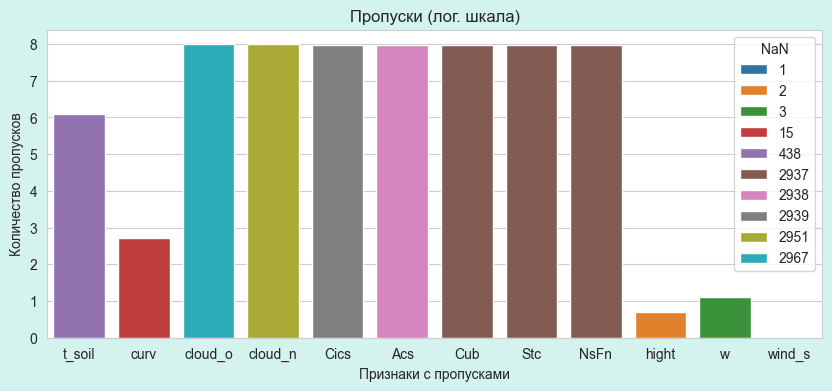

In [9]:
print(f"Data shape: {inf(df_meteo)[0]} × {inf(df_meteo)[1]}\
    \nDuplicated: {inf(df_meteo)[2]}\
    \nTotal NaN: {inf(df_meteo)[4]}\
    \nDetected NaN:")
display(inf(df_meteo)[3].T)

data_nan = inf(df_meteo)[3]
data_nan['feat_count'] = list(inf(df_meteo)[3].T.columns)
fig, axes = plt.subplots(figsize=(10, 4))
sns.barplot(data=data_nan,
            x = 'feat_count',
            y = np.log(data_nan['NaN']),
            hue='NaN',
            dodge=False)
axes.set_xlabel('Признаки с пропусками')
axes.set_ylabel('Количество пропусков')
axes.set_title('Пропуски (лог. шкала)');
# plt.grid()

Во фрейме имеется 21065 пропуска. Дубликатов нет. Но есть один момент на который нужно обратить внимание. Дело в том, что метеорологи-наблюдатели иногда записывали код подобным образом: `">98", ">97"` и т. п. То есть, значение более 98, более 97. Для нашего анализа это недопустимо и если есть такие записи, то их нужно исправить. Пока же просмотрим весь фрейм на наличие подобных артефактов. Все возможные их виды, с которыми столкнулся при конвертации, я указал в списке `art`.

In [10]:
# Просмотр артефактов во фрейме.  
art = ['*', '?', '$', 'H', '>', '<']
lst_art = []
for i in range(len(df_meteo)):
    for j in df_meteo.columns:
        x = str(df_meteo[j][i])
        if (x[0] in art) or (x[-1]) in art:
            lst_art.append(j)
        
if len(lst_art) == 0:
    print("Artifacts not detected")
else:
    print("Artifacts in columns: ", *set(lst_art))

Artifacts in columns:  visib


Мы выяснили, что:
- размер таблицы: 90584 × 32;
- количество пропусков: 21065;
- дубликатов не имеется;
- присутствуют артефакты в значениях столбца `"visib"`;
- имеются кодовые значения `"n/d"` и `"n/m"`;
- определили списки с категориальными и числовыми типами признаков;
- некоторые категориальные признаки должны быть числовыми, для чего с ними необходимо поработать.

<font color = '#360CCC'>

### **3.2. Визуализация. Анализ данных** <a class="anchor" id="3.2"></a>
</font>

Посмотрим баланс положительной и отрицательной температур.

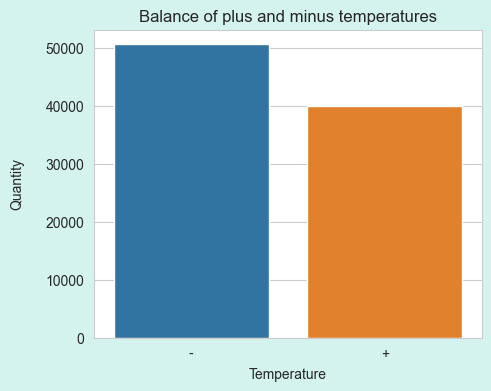

In [11]:
df_meteo['t_bal'] = df_meteo['t_bal'][df_meteo.t_air >=0] = '+'
df_meteo['t_bal'][df_meteo.t_air < 0] = '-'

fig, ax = plt.subplots(figsize=(5, 4), facecolor='#D4F3EF')
sns.countplot(data=df_meteo, x='t_bal');
ax.set_title('Balance of plus and minus temperatures')
ax.set_xlabel('Temperature')
ax.set_ylabel('Quantity\n')
df_meteo.drop(columns=['t_bal'], axis=0, inplace=True)

Поскольку городок северный, то там преобладают отрицательные температуры. Впрочем это нам показала описательная статистика, но на этом графике баланс температур показан весьма нагляднее.

Какова зависимость влажности от температуры воздуха? Строим диаграмму.

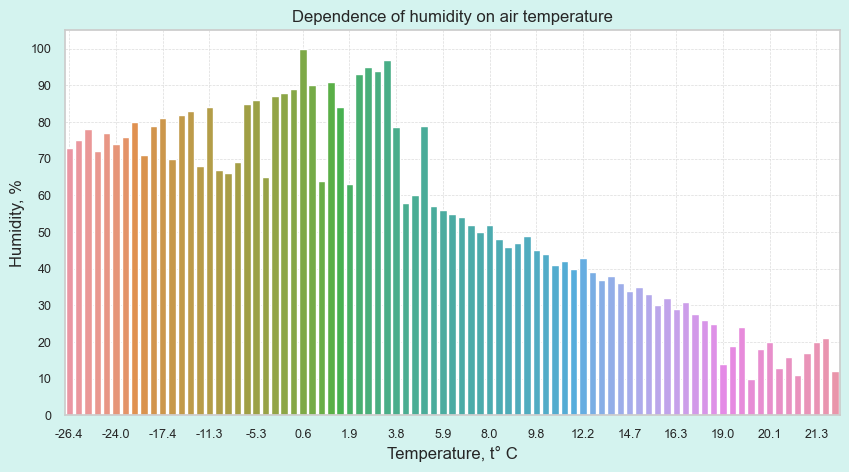

In [12]:
bar_df = df_meteo.groupby(['rh'], as_index=False)[['t_air']].mean().round(1)

sns.set_style("whitegrid",
              rc={'grid.color': '#DCDCDC', 'grid.linestyle': '--'})
sns.set_context("notebook",
                rc={'grid.linewidth': 0.5})

fig, axes = plt.subplots(figsize=(10, 5),facecolor='#D4F3EF')
sns.barplot(data=bar_df,x='t_air', y='rh', ax=axes, ci=None)
axes.set_title('Dependence of humidity on air temperature')
axes.set_xlabel('Temperature, t° C')
axes.set_ylabel('Humidity, %')
axes.xaxis.set_major_locator(ticker.MultipleLocator(5))
axes.yaxis.set_major_locator(ticker.MultipleLocator(10))
axes.xaxis.set_tick_params(labelsize = 9);
axes.yaxis.set_tick_params(labelsize = 9);
axes.grid(axis='x')
plt.show();


Влажность падает при увеличении температуры. Картина странная, обычно при увеличении температуры влажность увеличивается чуть ли не до 100%. После консультации с метеорологом всё стало на свои места. Оказывается город входит в число городов с наиболее сухим климатом в России. Климат у нас резко-континентальный и сухой, что и даёт такую картину зависимости влажности от температуры.

А что у нас с ветрами? Взглянем на графики зависимости скорости ветров от их направлений и соотношения направления ветров к их количеству. Направления ветров даны в градусах, поэтому переведу их в международное метеорологическое название, так гораздо удобнее ориентироваться, чем по градусам.

In [13]:
# Обработка значений wind_d в новый признак wind_dir
df_meteo['wind_dir'] = 'no data'
df_meteo['wind_dir'][df_meteo['wind_s'] <= 0.5] = 'stille'

dir_lst = ['NNE', 'NE', 'ENE', 'E', 'ESE', 'SE', 'SSE', 'S', 
           'SSW', 'SW', 'WSW', 'W', 'WNW', 'NW', 'NNW']
c1, c2 = 22, 23
dir1, dir2, dir_x = 12, 33, 0
df_meteo['wind_dir'][(df_meteo['wind_s'] > 0.5) & 
        ((df_meteo['wind_d'] >= 349) | (df_meteo['wind_d'] <= 11))] = 'N'
for item in dir_lst:
    df_meteo['wind_dir'][(df_meteo['wind_d'] >= dir1) & (
        df_meteo['wind_d'] <= dir2)] = item
    dir_x = dir1
    dir1 = dir2 + 1
    dir2 = dir_x + 44

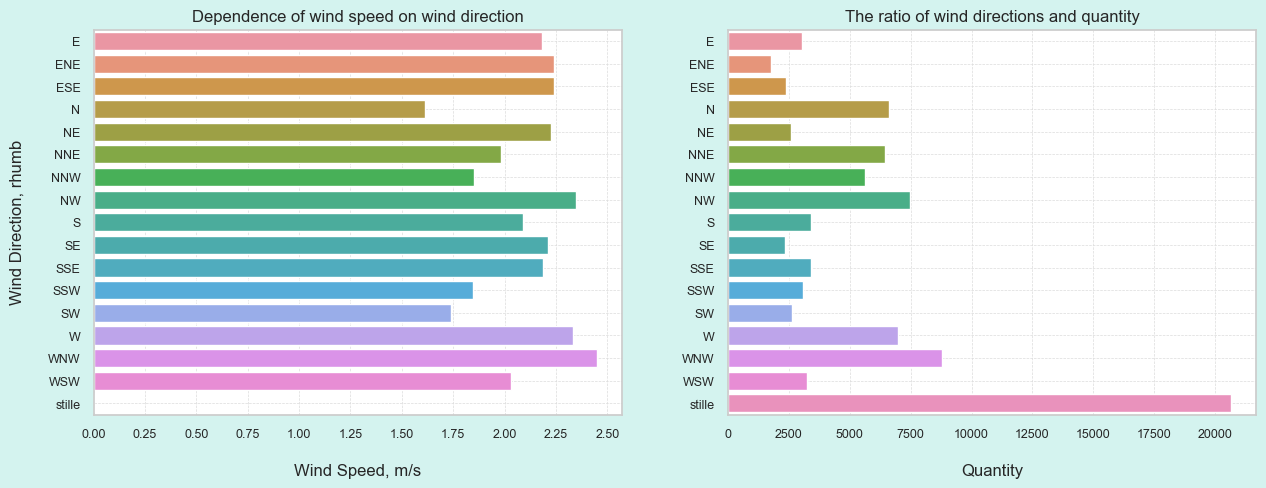

In [14]:
sns.set_style("whitegrid",
              rc={'grid.color': '#DCDCDC', 'grid.linestyle': '--'})
sns.set_context("notebook",
                rc={'grid.linewidth': 0.5})

dfd = df_meteo.sort_values(by=['wind_s'])
df_meteo['numb'] = 0
df_count = df_meteo.groupby(['wind_dir'], 
                            as_index=False).agg({'numb': 'count'})

dfd = df_meteo.sort_values(by='wind_dir', ascending=True)

fig, ax = plt.subplots(1, 2, figsize=(15, 5),facecolor='#D4F3EF')
sns.barplot(data=dfd,x='wind_s', y='wind_dir', ax=ax[0], ci=None)
ax[0].set_title('Dependence of wind speed on wind direction')
ax[0].set_xlabel('\nWind Speed, m/s')
ax[0].set_ylabel('Wind Direction, rhumb\n')
ax[0].xaxis.set_major_locator(ticker.MultipleLocator(0.25))
ax[0].xaxis.set_tick_params(labelsize = 9);
ax[0].yaxis.set_tick_params(labelsize = 9);
ax[0].grid(True)
dfc = df_count.sort_values(by='wind_dir', ascending=True)

sns.barplot(data=dfc, y='wind_dir', x='numb', ax=ax[1], ci=None)
ax[1].set_title('The ratio of wind directions and quantity')
ax[1].set_ylabel('')
ax[1].set_xlabel('\nQuantity')
ax[1].xaxis.set_tick_params(labelsize = 9);
ax[1].yaxis.set_tick_params(labelsize = 9);
ax[1].grid(True)

plt.show();
df_meteo.drop(columns='numb', inplace=True)

А теперь построим розу ветров и сделаем по графикам выводы. В розе ветров имеется много информация, в том числе и часть того, что содержится в верхних графиках.

In [15]:
# Подготовка фрейма для построения розы ветров
rdf = df_meteo[['wind_s', 'wind_dir', 'wind_d']]
rdf = rdf[rdf['wind_dir'] != 'stille']
rdf = rdf.rename(columns={'wind_s': 'VELOCIDAD', 
                          'wind_dir': 'DIRECCARD', 'wind_d': 'DIRECCION'})
rdf = rdf.reset_index(drop=True)

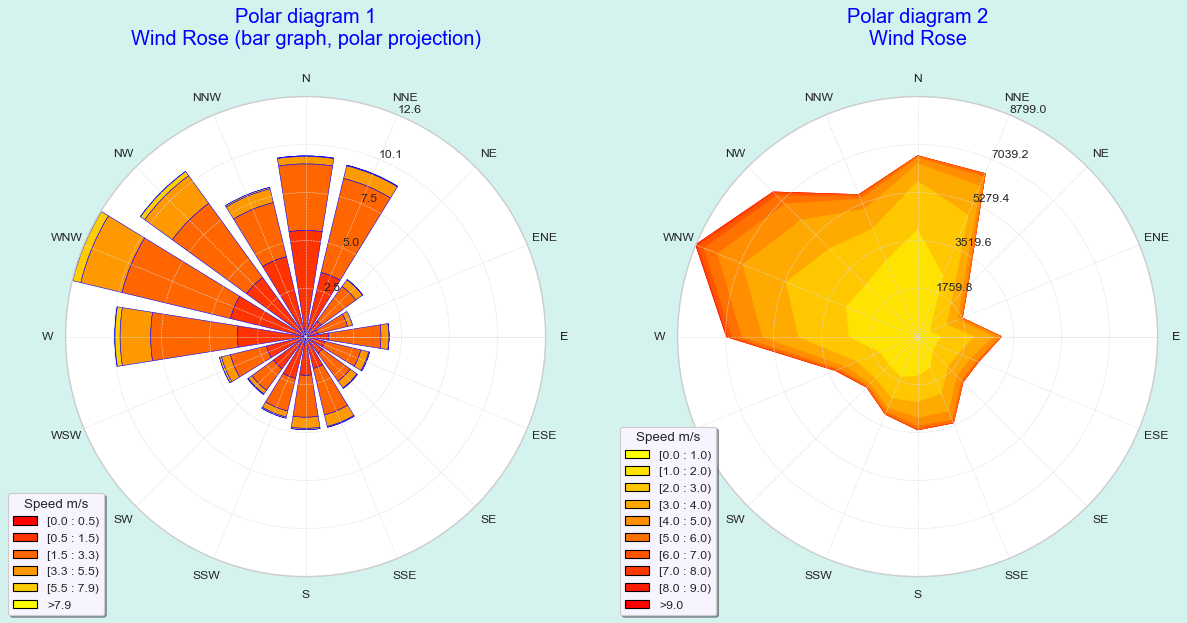

In [16]:
def new_axes(fig, rect):
    ax = WindroseAxes(fig, rect)
    fig.add_axes(ax)
    return ax

def set_legend(ax):
    ax.legend(bbox_to_anchor=( -0.12 , -0.08 ),
              title='Speed m/s', shadow=True, 
              facecolor='#F8F4FF', borderaxespad= 0)

rect1 = [0.1, 0.1, 0.4, 0.4]
rect2 = [0.61, 0.1, 0.4, 0.4]
lst_grd = [360, 337.5, 315, 292.5, 270, 247.5, 225, 202.5, 180, 
           157.5, 135, 112.5, 90, 67.5, 45, 22.5, 0]
lst_rumb = ['E', 'ESE', 'SE', 'SSE', 'S', 'SSW', 'SW', 'WSW', 'W',
            'WNW', 'NW', 'NNW', 'N', 'NNE', 'NE', 'ENE', 'E']

fig = plt.figure(figsize=(15, 15), dpi=80, facecolor='#D4F3EF', edgecolor='w')

ax1 = new_axes(fig, rect1)
ax2 = new_axes(fig, rect2)

# Не совсем роза, используется столбчатый график в полярной проекции
ax1.bar(rdf['DIRECCION'], rdf['VELOCIDAD'], normed=True, opening=0.8, 
        bins=[0,0.5,1.5,3.3,5.5,7.9], edgecolor='blue', 
        lw=0.5, cmap=cm.autumn)
ax1.set_thetagrids(lst_grd, lst_rumb)
ax1.set_theta_zero_location('W', offset=-180)
ax1.set_title("Polar diagram 1\nWind Rose (bar graph, polar projection)\n", 
              size=18 , color='blue')
set_legend(ax1)

# Роза ветров
ax2.contourf(rdf['DIRECCION'], rdf['VELOCIDAD'], bins=np.arange(0, 10, 1),
             cmap= cm.autumn_r)
ax2.set_thetagrids(lst_grd, lst_rumb)
ax2.set_theta_zero_location('W', offset=-180)
ax2.set_title("Polar diagram 2\nWind Rose\n", size=18 , color='blue')
set_legend(ax2)

plt.show();

В диаграмме розы ветров по внешней окружности указаны румбы сторон света (N ─ север, S ─ юг, и т. д.). Концентрические окружности внутри первой диаграммы показывают скорость ветра м/с (2.0, 5.0, 7.5 и т. д.), внутри второй диаграммы ─ частоту появления ветров за 31 год в том или ином направлении (1759.8, 3519.6 и т. д.). Легенды показывают скорость ветра в м/с, которая соотносится каждая со своим цветом.  
Итак, самый частый гость за 31 год (в максимальном проявлении) ─ это западно-северо-западный (WNW) ветер, который появлялся около 8800 раз. И, к тому же, он имеет самую высокую скорость ветра за это время ─ около 12 м/с. Второе место по частоте и по скорости делят западный (W) и северо-западный (NW) ветра. Их скорость и частота практически одинаковы: максимальная скорость ─ около 10 м/с, частота западного ─ 7039, северо-западного ─ около 7500 раз. Ну и самый наименьший по всем параметрам ─ это восточно-северо-восточный ветер. За всё время он появлялся с минимальными скоростями около 1700 раз. Что же касается штиля, то в этой розе он не учитыватся, но по верхним графикам видно, что пальма первенства по частоте появления за 31 год принадлежит ему ─ более 20000 раз.  
Такая роза ветров весьма пригодится при планировании строительства технических сооружений, фабрик, заводов, при возведении жилых массивов, аэропортов. Практически в любой отрасли требуется роза ветров.  
Ну а мы идём дальше и посмотрим, есть ли зависимость между атмосферным давлением и температурой воздуха.

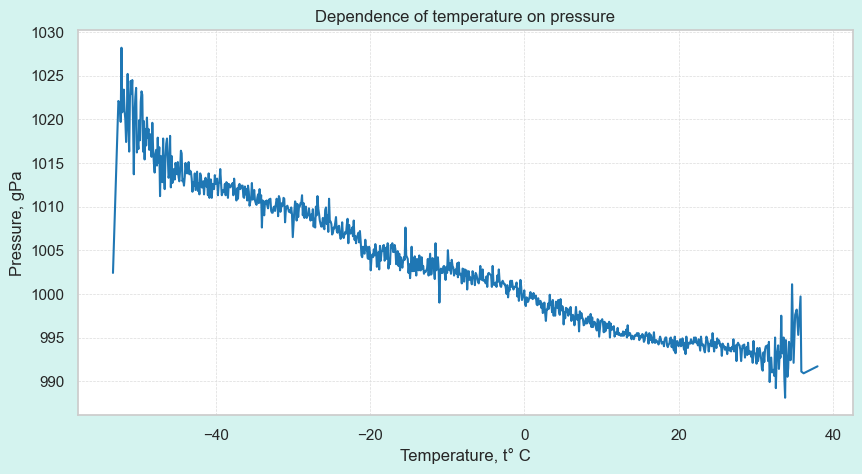

In [17]:
bar_df = df_meteo.groupby(['t_air'], 
                          as_index=False)[['atm_press']].mean().round(1)

sns.set_style("whitegrid",
              rc={'grid.color': '#DCDCDC', 'grid.linestyle': '--'})
sns.set_context("notebook",
                rc={'grid.linewidth': 0.5})

fig, axes = plt.subplots(figsize=(10, 5),facecolor='#D4F3EF')
sns.lineplot(data=bar_df,x='t_air', y='atm_press')
axes.set_title('Dependence of temperature on pressure')
axes.set_xlabel('Temperature, t° C')
axes.set_ylabel('Pressure, gPa')
plt.show();

Как видим, некоторая зависимость есть. Чем холоднее, тем выше давление, которое понижается с повышением температуры. Интересно будет узнать коэффицент корреляции между давлением и температурой. А сейчас предварительный анализ заканчиваем и переходим к четвёртому шагу ─ очистке.

<font color = '#360CCC'>

# **4. Очистка данных. Кодировка и ресемплирование** <a class="anchor" id="4"></a>
-----------------------

Перед тем, как приступим к очистке, создадим новый датафрейм в котором будут только те значения, которые необходимы для прогноза температуры. Итак, анализируем:  
  
 ✔️ `t_soil` ─ температура почвы, оставляем;  
 ❎ `t_dew` ─ температура точки росы, не нужна;  
 ✔️ `partial` ─ парциальное давление водяного пара, вообще-то не нужно, но оставлю;  
 ✔️ `rh` ─ относительная влажность, оставляем;  
 ❎ `sd` ─ дефицит насыщения, не нужен;  
 ✔️ `atm_press` ─ атмосферное давление, оставляем;  
 ❎ `sea_press` ─ атмосферное давление на уровне моря, не нужно;  
 ✔️ `curv` ─ кривая барической тенденции, оставляем;  
 ✔️ `bar_trend` ─ барическая тенденция, оставляем;  
 ❎ `visib` ─ видимость, не нужна;  
 ❎ `cloud_o` ─ количество облаков верхнего яруса, не нужно;  
 ❎ `cloud_n` ─ количество облаков нижнего яруса, не нужно;  
 ❎ `Cics` ─ тип облачности, не нужен;  
 ❎ `Acs` ─ тип облачности, не нужен;  
 ❎ `Cub` ─ тип облачности, не нужен;  
 ❎ `Stc` ─ тип облачности, не нужен;  
 ❎ `NsFn` ─ тип облачности, не нужен;  
 ❎ `high` ─ высота нижней кромки облака, не нужна;  
 ❎ `foll`─ высота облачности под станцией (в высокогорных условиях), не нужна;  
 ❎ `w` ─ коды прогноза, не нужны;  
 ❎ `ww` ─ коды прогноза, не нужны;  
 ❎ `wind_d` ─ направление ветра в градусах, не нужно;  
 ✔️ `wind_dir` ─ направление ветра в румбах, оставляем;  
 ✔️ `wind_s` ─ скорость ветра, оставляем;  
 ❎ `rainfall` ─ количество осадков, не нужно.  
  
Хочу сказать, что выборку я делал не по своему разумению, а предварительно проконсультировавшись со специалистом-метеорологом, который разъяснил мне от каких факторов зависит температура воздуха.  
  
Создаём датафрейм в котором будут признаки, связанные с температурой. Попутно переименуем `rh` на более понятное название `humidity` ─ влажность.

In [18]:
df = df_meteo[['date', 't_air', 't_soil', 'partial', 'rh', 'curv', 
               'bar_trend', 'atm_press', 'wind_dir', 'wind_s']]
df = df.rename(columns={'rh': 'humidity'})
inf(df, 3)[0:2]

date  t_air  t_soil  partial  humidity  curv  bar_trend  \
0  1990-01-01 00:00:00  -33.1   -36.0     0.29        77   2.0        0.5   
1  1990-01-01 03:00:00  -32.1   -32.0     0.34        78   2.0        2.5   
2  1990-01-01 06:00:00  -30.2   -31.0     0.40        78   2.0        0.8   

   atm_press wind_dir  wind_s  
0     1011.1       NW     1.0  
1     1013.6   stille     0.0  
2     1014.4      SSW     1.0

(90584, 10)

Мы получили датасет со следующими признаками:  
- `date` ─ дата;  
- `t_air` ─ температура воздуха, t° C;  
- `t_soil` ─ температура почвы, t° C;  
- `humidity` ─ относительная влажность, %;  
- `curv` ─ кривая барической тенденции, (код в зависимости от вида кривой);  
- `bar_trend` ─ барическая тенденция, гПа (гектаПаскаль);  
- `atm_press` ─ атмосферное давление на уровне станции, гПа;  
- `bar_trend` ─ барическая тенденция, гПа;  
- `wind_dir` ─ направление ветра, румбы;  
- `wind_s` ─ скорость ветра, м/с.



Проверим вновь полученный датасет на пропуски и дубликаты.

In [19]:
print(f"Data shape: {inf(df)[0]} × {inf(df_meteo)[1]}\
    \nDuplicated: {inf(df)[2]}\
    \nDetected NaN: {inf(df)[4]}")
display(inf(df)[3].T)

Data shape: 90584 × 31    
Duplicated: 0    
Detected NaN: 454


t_soil  curv  wind_s
NaN     438    15       1

Как и ожидалось, пропуски "переехали" из старого датафрейма, дубликатов нет. Избавляемся от пропусков.

<font color = '#360CCC'>
<!-- <font color = 'Gold'> -->

### **4.1. Признак «t_soil»** <a class="anchor" id="4.1"></a>
</font>

Первым будет признак `t_soil` (температура почвы). Количество пропусков в нём за 31 год всего 438. Эти пропуски, вероятно, либо человеческий фактор, либо техническая неисправность. Эти пропуски заменю температурой воздуха, предарительно увеличив её на 1°С при минусовой температуре и уменьшив на 1°С при плюсовой температуре. Среднее  или медианное значение здесь не подойдёт, так как температура меняется каждые сутки, а здесь пропуски следуют один за другим по индексу и получается большая полоса пропусков в данных температуры почвы. Поэтому обратимся к температуре воздуха.

In [20]:
print(clean_b(df.t_soil))

# Замена NaN в t_soil соответствующими значениями t°С.  
for i, val in enumerate(df['t_soil']):
    if pd.isna(val) is True and df['t_air'][i] < 0:
        df.loc[i, 't_soil'] = df['t_air'][i]+1
    if pd.isna(val) is True and df['t_air'][i] > 0:
        df.loc[i, 't_soil'] = df['t_air'][i]-1

print(clean_a(df.t_soil))

NaN before cleaning: 438
NaN after cleaning: 0


<font color = '#360CCC'>
<!-- <font color = 'Gold'> -->

### **4.2. Признак «curv»** <a class="anchor" id="4.2"></a>
</font>  
Заменяем пропуски значениями, которые стоят в верхней строке, так как за три часа (интервал срока) кривая барической тенденции вряд ли сильно изменится.

In [21]:
print(clean_b(df.curv))

lst = list(df[df['curv'].isnull() == True].index)
for i in lst:
    df.loc[i, 'curv'] = df.loc[i-1, 'curv']
    
print(clean_b(df.curv))

NaN before cleaning: 15
NaN before cleaning: 0


<font color = '#360CCC'>
<!-- <font color = 'Gold'> -->

### **4.3. Признак «wind_s»** <a class="anchor" id="4.3"></a>
</font>

Теперь определимся с единичным пропуском в признаке скорости ветра. Заменим пропуск средним от значений строк сверху и снизу.

In [22]:
print(clean_b(df.wind_s))

# Замена единичного пропуска в wind_s.  
indx = df[df['wind_s'].isnull() == True].index
df.loc[indx[0], 'wind_s'] = df.loc[indx[0]-3:indx[0]+4, 'wind_s'].mean().round()

print(clean_a(df.wind_s))

NaN before cleaning: 1
NaN after cleaning: 0


<font color = '#360CCC'>
<!-- <font color = 'Gold'> -->

### **4.4. Признак «wind_dir». Кодировка** <a class="anchor" id="4.4"></a>
</font>
Проведём кодировку этого признка с помощью OneHotEncoder. Переменная у нас категориальная со многими значениями, поэтому кодировка необходима. Исходный признак удалим.

In [23]:
ohe = ce.OneHotEncoder(cols=['wind_dir'], use_cat_names=True)
dir_bin = ohe.fit_transform(df['wind_dir'])
df = pd.concat([df, dir_bin], axis=1)
df.drop(columns='wind_dir', inplace=True)

Наличие пропусков и дубликатов после очистки.

In [24]:
print(f"Data shape: {inf(df)[0]} × {inf(df)[1]}\
    \nDuplicated: {inf(df)[2]}\
    \n{inf(df)[3]}")

Data shape: 90584 × 26    
Duplicated: 0    
NaN not detected.


Типы признаков.

In [25]:
feature_cat = [feature for feature in df.columns if df[feature].dtypes == "O"]
feature_num = [feature for feature in df.columns if df[feature].dtypes != "O"]
print("Категориальные признаки: ", feature_cat)
print("Числовые признаки: ", feature_num)

Категориальные признаки:  ['date']
Числовые признаки:  ['t_air', 't_soil', 'partial', 'humidity', 'curv', 'bar_trend', 'atm_press', 'wind_s', 'wind_dir_NW', 'wind_dir_stille', 'wind_dir_SSW', 'wind_dir_W', 'wind_dir_WSW', 'wind_dir_ESE', 'wind_dir_NNW', 'wind_dir_N', 'wind_dir_S', 'wind_dir_NNE', 'wind_dir_NE', 'wind_dir_WNW', 'wind_dir_SSE', 'wind_dir_SW', 'wind_dir_ENE', 'wind_dir_SE', 'wind_dir_E']


In [26]:
display(df.info())
df.describe()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 90584 entries, 0 to 90583
Data columns (total 26 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   date             90584 non-null  object 
 1   t_air            90584 non-null  float64
 2   t_soil           90584 non-null  float64
 3   partial          90584 non-null  float64
 4   humidity         90584 non-null  int64  
 5   curv             90584 non-null  float64
 6   bar_trend        90584 non-null  float64
 7   atm_press        90584 non-null  float64
 8   wind_s           90584 non-null  float64
 9   wind_dir_NW      90584 non-null  int64  
 10  wind_dir_stille  90584 non-null  int64  
 11  wind_dir_SSW     90584 non-null  int64  
 12  wind_dir_W       90584 non-null  int64  
 13  wind_dir_WSW     90584 non-null  int64  
 14  wind_dir_ESE     90584 non-null  int64  
 15  wind_dir_NNW     90584 non-null  int64  
 16  wind_dir_N       90584 non-null  int64  
 17  wind_dir_S  

None

t_air        t_soil       partial      humidity          curv  \
count  90584.000000  90584.000000  90584.000000  90584.000000  90584.000000   
mean      -7.843844     -7.784817      4.776618     68.258810      4.580986   
std       21.841433     24.090071      5.131883     17.677575      2.449093   
min      -53.300000    -58.000000      0.030000     10.000000      0.000000   
25%      -29.100000    -31.000000      0.420000     58.000000      2.000000   
50%       -4.000000     -4.000000      2.880000     73.000000      4.000000   
75%       11.300000     12.000000      7.900000     80.000000      7.000000   
max       38.000000     54.000000     34.800000    100.000000      8.000000   

          bar_trend     atm_press        wind_s   wind_dir_NW  \
count  90584.000000  90584.000000  90584.000000  90584.000000   
mean       0.768174   1002.446920      1.631293      0.082686   
std        0.701293     10.357253      1.397419      0.275408   
min        0.000000    967.900000      0.000000      0.000000   
25%        0.300000    994.900000      1.000000      0.000000   
50%        0.600000   1001.300000      1.000000      0.000000   
75%        1.100000   1009.300000      2.000000      0.000000   
max       10.400000   1043.300000     12.000000      1.000000   

       wind_dir_stille  wind_dir_SSW    wind_dir_W  wind_dir_WSW  \
count     90584.000000  90584.000000  90584.000000  90584.000000   
mean          0.227888      0.033957      0.077298      0.035834   
std           0.419472      0.181121      0.267066      0.185877   
min           0.000000      0.000000      0.000000      0.000000   
25%           0.000000      0.000000      0.000000      0.000000   
50%           0.000000      0.000000      0.000000      0.000000   
75%           0.000000      0.000000      0.000000      0.000000   
max           1.000000      1.000000      1.000000      1.000000   

       wind_dir_ESE  wind_dir_NNW    wind_dir_N    wind_dir_S  wind_dir_NNE  \
count  90584.000000  90584.000000  90584.000000  90584.000000  90584.000000   
mean       0.026594      0.062108      0.073114      0.037656      0.071337   
std        0.160895      0.241353      0.260326      0.190363      0.257389   
min        0.000000      0.000000      0.000000      0.000000      0.000000   
25%        0.000000      0.000000      0.000000      0.000000      0.000000   
50%        0.000000      0.000000      0.000000      0.000000      0.000000   
75%        0.000000      0.000000      0.000000      0.000000      0.000000   
max        1.000000      1.000000      1.000000      1.000000      1.000000   

        wind_dir_NE  wind_dir_WNW  wind_dir_SSE   wind_dir_SW  wind_dir_ENE  \
count  90584.000000  90584.000000  90584.000000  90584.000000  90584.000000   
mean       0.028548      0.097136      0.037733      0.028946      0.019485   
std        0.166533      0.296145      0.190551      0.167654      0.138222   
min        0.000000      0.000000      0.000000      0.000000      0.000000   
25%        0.000000      0.000000      0.000000      0.000000      0.000000   
50%        0.000000      0.000000      0.000000      0.000000      0.000000   
75%        0.000000      0.000000      0.000000      0.000000      0.000000   
max        1.000000      1.000000      1.000000      1.000000      1.000000   

        wind_dir_SE    wind_dir_E  
count  90584.000000  90584.000000  
mean       0.025899      0.033781  
std        0.158834      0.180665  
min        0.000000      0.000000  
25%        0.000000      0.000000  
50%        0.000000      0.000000  
75%        0.000000      0.000000  
max        1.000000      1.000000

<font color = '#360CCC'>
<!-- <font color = 'Gold'> -->

### **4.5. Ресемплирование** <a class="anchor" id="4.5"></a>
</font>
Чтобы у нас были одинаковые данные для всех моделей, необходимо провести передискретизацию на месяцы. То есть во временных рядах и нейронной модели используется датасет по месяцам, а наша задача ─ сравнить модели по качеству прогноза между собой, поэтому для линейной регрессиии сделаем такой же датасет. Проведём передискретизацию на дни, а затем на месяцы.

In [27]:
# Установка даты в качестве индекса
df['date'] = pd.to_datetime(df['date'])
df = df.set_index('date')

# Ресемплирование по дням
df_day = df.resample('D').mean()
print(f"Ресемплировано строк: {df.shape[0]-df_day.shape[0]}")

# Ресемплирование по месяцам
df_mon = df_day.resample('M').mean()
print(f"Ресемплировано строк: {df_day.shape[0]-df_mon.shape[0]}")
lst_date = df_mon.index
df_mon.head(2)

Ресемплировано строк: 79261
Ресемплировано строк: 10951


t_air     t_soil   partial   humidity      curv  bar_trend  \
date                                                                         
1990-01-31 -42.405645 -42.366935  0.130323  74.391129  4.616935   0.597177   
1990-02-28 -35.930804 -36.620536  0.281295  75.883929  4.821429   0.661161   

              atm_press    wind_s  wind_dir_NW  wind_dir_stille  wind_dir_SSW  \
date                                                                            
1990-01-31  1015.680645  0.451613     0.020161         0.625000      0.020161   
1990-02-28  1015.812946  0.544643     0.040179         0.611607      0.008929   

            wind_dir_W  wind_dir_WSW  wind_dir_ESE  wind_dir_NNW  wind_dir_N  \
date                                                                           
1990-01-31    0.040323      0.036290      0.004032      0.052419    0.088710   
1990-02-28    0.026786      0.013393      0.000000      0.044643    0.084821   

            wind_dir_S  wind_dir_NNE  wind_dir_NE  wind_dir_WNW  wind_dir_SSE  \
date                                                                            
1990-01-31    0.024194      0.052419     0.012097      0.020161      0.004032   
1990-02-28    0.004464      0.084821     0.008929      0.049107      0.008929   

            wind_dir_SW  wind_dir_ENE  wind_dir_SE  wind_dir_E  
date                                                            
1990-01-31     0.000000      0.000000          0.0         0.0  
1990-02-28     0.008929      0.004464          0.0         0.0

<font color = '#360CCC'>

# **5. Разведывательный анализ данных** <a class="anchor" id="5"></a>
-------------------------------
</font>

<font color = '#360CCC'>

### **5.1. Поиск выбросов** <a class="anchor" id="5.1"></a>
</font>

Построим общую диаграмму "ящиков с усами" числовых признаков, чтобы определиться с выбросами.  
Создадим список столбцов без кодированных признаков.

In [28]:
num_cols = df_mon[['t_air', 't_soil', 'partial', 'humidity', 'curv', 
                   'bar_trend', 'atm_press', 'wind_s']].columns.to_list()

Смотрим выбросы в некодированных признаках.

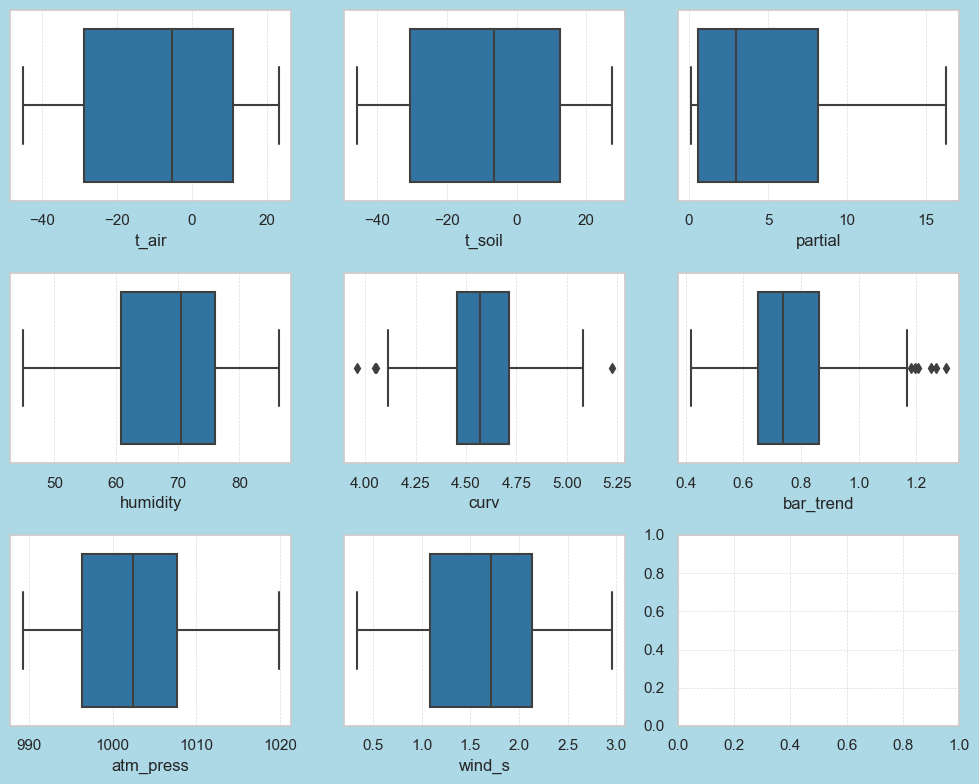

In [29]:
fig, axes = plt.subplots(int(np.ceil(len(num_cols)/3)),
                         3, figsize = (10, 8), facecolor='lightblue')
for i, att in zip(range(len(num_cols)), num_cols):
    sns.boxplot(ax = axes[int(np.floor(i/3))][i%3], 
                x = att, data = df_mon)
plt.tight_layout()

В четырёх признаках имеются выбросы. Используем метод z-отклонения для определения границ межквантильного диапазона и последующей корректировки.  

In [30]:
# Функция определения диапазона и коррекции.  
def bord(data, feature, corr=False):
    x = data[feature]
    fm = x.mean()
    sigma = x.std()
    low = (fm - 3 * sigma).round(1)
    up = (fm + 3 * sigma).round(1)
    out = data[(x < (fm-3*sigma)) | (x > (fm+3*sigma))].shape[0]
    if corr == False:
        return f"Признак: {feature}\nЧисло выбросов: {out}\n\
Нижний предел: {low}\nВерхний предел: {up}\n"
    if corr == True:
        data[feature][data[feature] > up] = up
        return f"Признак: {feature}\nКоррекция по выбросам проведена.\n"

print(bord(df_mon, 'curv'))
print(bord(df_mon, 'bar_trend'))

Признак: curv
Число выбросов: 2
Нижний предел: 4.0
Верхний предел: 5.1

Признак: bar_trend
Число выбросов: 2
Нижний предел: 0.3
Верхний предел: 1.3



In [31]:
print(bord(df_mon, 'curv', corr=True))
print(bord(df_mon, 'bar_trend', corr=True))

Признак: curv
Коррекция по выбросам проведена.

Признак: bar_trend
Коррекция по выбросам проведена.



<font color = '#360CCC'>

### **5.2. Распределение в признаках** <a class="anchor" id="5.2"></a>
</font>

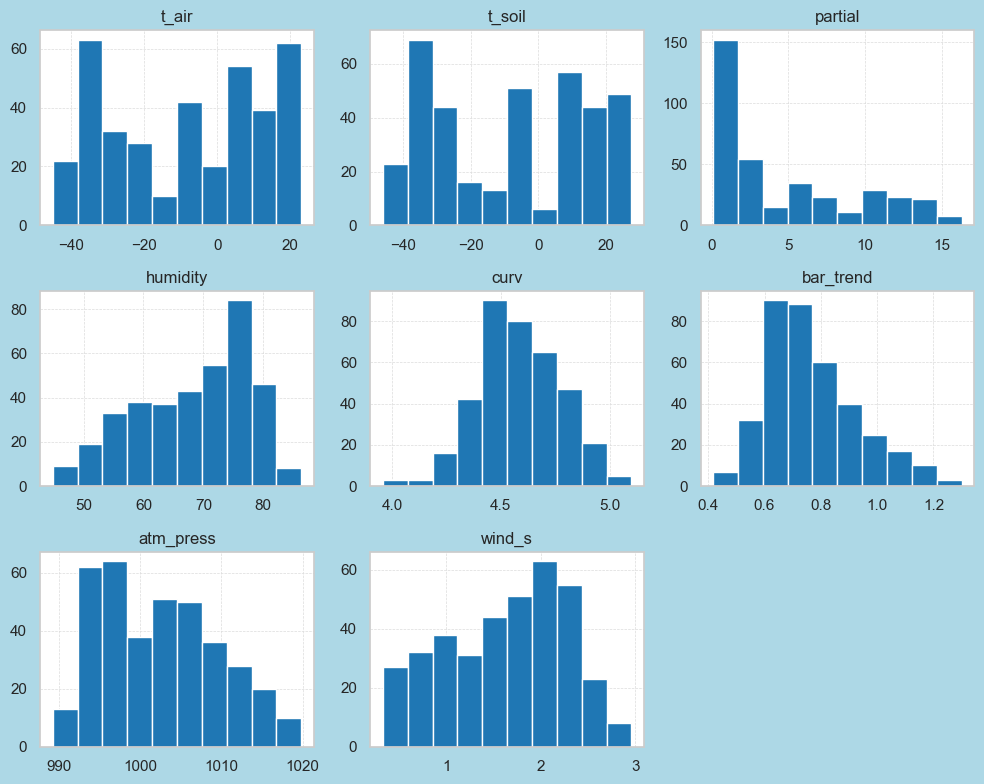

In [32]:
rcParams['figure.figsize'] = 10, 8
rcParams['figure.facecolor'] = 'lightblue'
df_mon[num_cols].hist()
plt.tight_layout();

Чем-то, напоминающим нормальное распределение, показывает себя `bar_trend` и `curv`, но фактически, ни в одном признаке нет нормального распределения.  
Составим тепловую карту корреляций и, поскольку у нас есть переменные, которые не являются нормально распределёнными, а также наличествуют небольшие выбросы, то применим метод корреляции Кендалла.

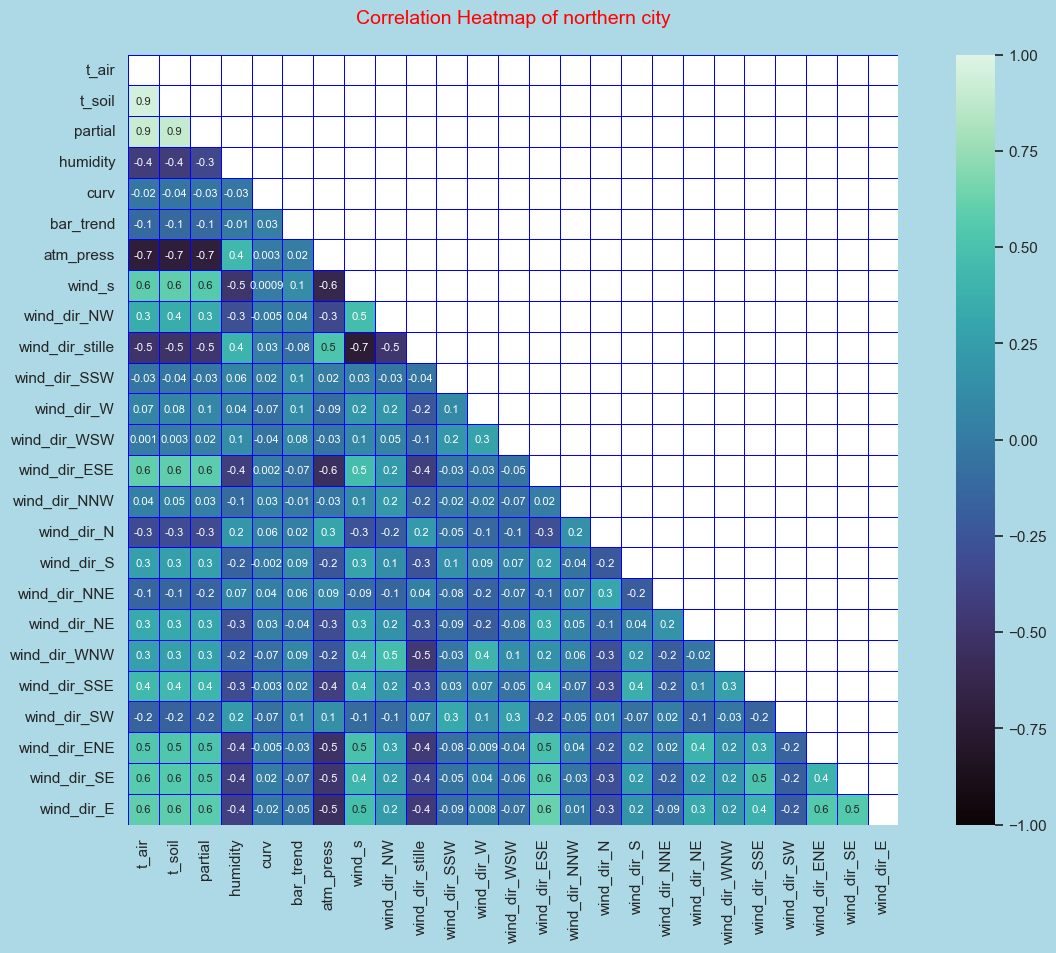

In [33]:
correlation = df_mon.corr(method='kendall')
matrix = np.triu(correlation)

# Построение тепловой карты
fig, ax = plt.subplots(figsize=(15, 10))
ax.set_title('Correlation Heatmap of northern city', fontsize=14, color='red', \
    y=1.03, ha='center')
sns.heatmap(
    correlation, square=True, annot=True, mask = matrix,
    annot_kws={"fontsize": 8}, vmin=-1, vmax=1, center=0,
    cmap='mako', linewidth=0.5, linecolor='blue', fmt='.0g', ax=ax)
fig.show()

Карта получилась большая, читать неудобно. Оставим на ней только коэффиценты, которые больше 0.7 или меньше -0.7.

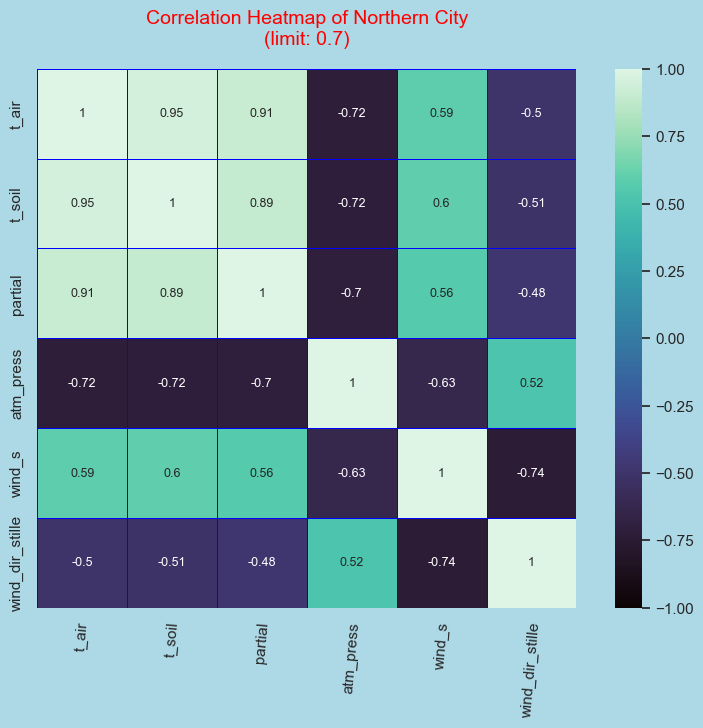

In [34]:
def heat_map(lim=0.5):
    correl = df_mon.corr(method='kendall')
    high_corr = [] 
    for i in correl.columns:
        for j in range(correl.shape[0]):
            if (correl[i][j] != 1.0) and (abs(correl[i][j]) > lim):
                high_corr.append(i)
                break

    df_corr = correl[high_corr].loc[high_corr]
    fig, ax = plt.subplots(figsize=(10, 7))
    ax.set_title(f'Correlation Heatmap of Northern City\n\
(limit: {lim})', fontsize=14, color='red', \
        y=1.03, ha='center')
    sns.heatmap(df_corr, square=True,
        annot=True, annot_kws={"fontsize": 9}, 
        vmin=-1, vmax=1, center=0,
        cmap='mako', linewidth=0.5, 
        linecolor='blue', fmt='.2g', ax=ax)
    ax.set_xticklabels(ax.get_xticklabels(), rotation=85)
    return fig    

heat_map(0.7).show()

Очень сильная связь между признаками `t_air` ─ `t_soil`, `t_air` ─ `partial` объясняется тем, что температуры воздуха и почвы взаимосвязаны между собой, а от них зависит парциальное давление. Придётся удалить столбец `t_soil`. Очень не хочется, но придётся ─ связь чрезвычайно сильная, значения температур воздуха и почвы почти одинаковые. Удаляем.

In [35]:
df_mon.drop(columns='t_soil', inplace=True)
df_mon.head(2)

t_air   partial   humidity      curv  bar_trend    atm_press  \
date                                                                           
1990-01-31 -42.405645  0.130323  74.391129  4.616935   0.597177  1015.680645   
1990-02-28 -35.930804  0.281295  75.883929  4.821429   0.661161  1015.812946   

              wind_s  wind_dir_NW  wind_dir_stille  wind_dir_SSW  wind_dir_W  \
date                                                                           
1990-01-31  0.451613     0.020161         0.625000      0.020161    0.040323   
1990-02-28  0.544643     0.040179         0.611607      0.008929    0.026786   

            wind_dir_WSW  wind_dir_ESE  wind_dir_NNW  wind_dir_N  wind_dir_S  \
date                                                                           
1990-01-31      0.036290      0.004032      0.052419    0.088710    0.024194   
1990-02-28      0.013393      0.000000      0.044643    0.084821    0.004464   

            wind_dir_NNE  wind_dir_NE  wind_dir_WNW  wind_dir_SSE  \
date                                                                
1990-01-31      0.052419     0.012097      0.020161      0.004032   
1990-02-28      0.084821     0.008929      0.049107      0.008929   

            wind_dir_SW  wind_dir_ENE  wind_dir_SE  wind_dir_E  
date                                                            
1990-01-31     0.000000      0.000000          0.0         0.0  
1990-02-28     0.008929      0.004464          0.0         0.0

Добавим столбцы дат ─ `year`, `month`, `day`.

In [36]:
df_mon.reset_index(inplace=True)
df_mon['year'] = df_mon['date'].dt.year
df_mon['month'] = df_mon['date'].dt.month
df_mon['day'] = df_mon['date'].dt.day
df_mon = df_mon.set_index('date')

<center><font color = '#360CCC'>

# **6. Линейная регрессия** <a class="anchor" id="6"></a>
-----------------------------------
</font></center>

<font color = '#360CCC'>

### **6.1. Разделение и обучение** <a class="anchor" id="6.1"></a>
</font>
При разделении датасета я хотел было воспользоваться train_test_split(), но тогда невозможно будет корректно сравнить результаты для разных моделей. Поэтому пришлось разделять таким образом.

In [37]:
# Разделение датасета.  
X_train = df_mon.loc[:'2017-12-31'].drop(columns='t_air')
X_test = df_mon.loc['2018-01-31':].drop(columns='t_air')
y_train = df_mon['t_air'].loc[:'2017-12-31']
y_test = df_mon['t_air'].loc['2018-01-31':]

# Сохраняем в списках индексы.  
lst_indx_test = X_test.index
lst_indx_train = X_train.index
prediction = pd.DataFrame({'alpha':0, 't_air':y_test}, index = lst_indx_test)

Проведём масштабирование перед обучением с помощью MinMaxScaler(). Для данной модели линейной регрессии масштабирование можно не проводить, но я решил включить его в процесс.

In [38]:
cols = X_test.columns
min_max_scal = MinMaxScaler()

X_train = min_max_scal.fit_transform(X_train)
X_test = min_max_scal.transform(X_test)

train = pd.DataFrame(X_train, columns=[cols], index=lst_indx_train)
test = pd.DataFrame(X_test, columns=[cols], index=lst_indx_test)

In [39]:
# Подключение линейной регрессии и обучение.  
lin_reg = linear_model.LinearRegression()
lin_reg.fit(train, y_train)

# Прогнозирование.  
pred = lin_reg.predict(test)

<font color = '#360CCC'>

### **6.2. Итоговая диаграмма линейной регерессии. Метрики** <a class="anchor" id="6.2"></a>
</font>
Заполняем датафрейм прогнозом линейной регрессии и доверительным интервалом на 95%. Этот фрейм нужен для построения результирующей диаграммы.

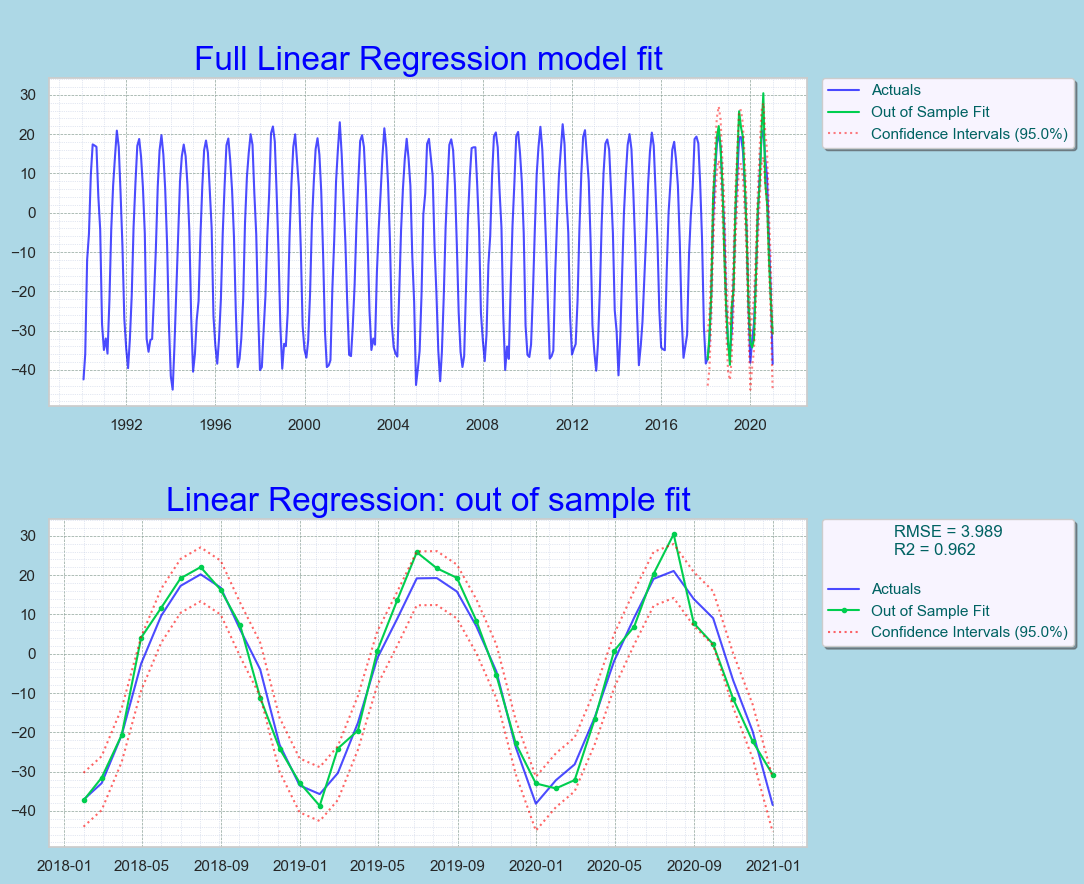

In [40]:
# Заполняем фрейм.  
df_predict(lr=True)

# Строим диаграмму.  
full_graph('Linear Regression', 'lr_predicted').show();

Большинство предсказанных значений лежат в границах доверительного интервала, однако, есть выходы за его пределы. Тем не менее, значение метрики RMSE и коэффициент детерминации показывают вполне неплохие результаты для линейной регрессии. Метрики можно улучшить, но тогда проект будет посвящён только линейной регрессии. :) А мы идём дальше и рассмотрим временные ряды.

<center><font color = '#360CCC'>

# **7. Временные ряды** <a class="anchor" id="7"></a>
-----------------------------------
</font></center>

С датасетом мы уже познакомились. Поскольку для временных рядов нам понадобится только один признак (не считая даты) с температурой воздуха, то подготовим соответствующий датафрейм.

In [41]:
data = pd.read_csv('data\meteo.csv')
data.head(2)

date  day  month  year   time  t_air  t_soil  t_dew  \
0  1990-01-01 00:00:00    1      1  1990  00:00  -33.1   -36.0  -36.0   
1  1990-01-01 03:00:00    1      1  1990  03:00  -32.1   -32.0  -34.3   

   partial  rh    sd  atm_press  sea_press  curv  bar_trend visib  cloud_o  \
0     0.29  77  0.10     1011.1     1025.7   2.0        0.5   n/d     10.0   
1     0.34  78  0.08     1013.6     1028.3   2.0        2.5   n/d     10.0   

   cloud_n  Cics  Acs  Cub  Stc  NsFn hight foll    w  ww  wind_d  wind_s  \
0      0.0   3.0  1.0  0.0  0.0   0.0   n/d  n/d  7.0  71     310     1.0   
1      0.0   3.0  1.0  0.0  0.0   0.0   n/d  n/d  7.0  71       0     0.0   

  rainfall  
0      n/d  
1      n/d

Из фрейма берём только два признака: `date` и `t_air`.

In [42]:
df = data[['date', 't_air']]

In [43]:
# Проверка на пропуски, дубликаты, размерность.  
print(f"Data shape: {inf(df)[0]} × {inf(df)[1]}\
    \nDuplicated: {inf(df)[2]}\
    \nTotal NaN: {inf(df)[3]}")

Data shape: 90584 × 2    
Duplicated: 0    
Total NaN: NaN not detected.


Пропуски и дубликаты в таблице отсутствуют. Устанавливаю дату в качестве индекса.

In [44]:
# Приведение к datetime и установка индекса
df['date'] = pd.to_datetime(df['date'])
df = df.set_index('date')
df.head()

t_air
date                      
1990-01-01 00:00:00  -33.1
1990-01-01 03:00:00  -32.1
1990-01-01 06:00:00  -30.2
1990-01-01 09:00:00  -27.0
1990-01-01 12:00:00  -28.4

<font color = '#360CCC'>

### **7.1. Анализ метеорологических данных температур** <a class="anchor" id="7.1"></a>
</font>

Взглянем на температуру по срокам за все года.

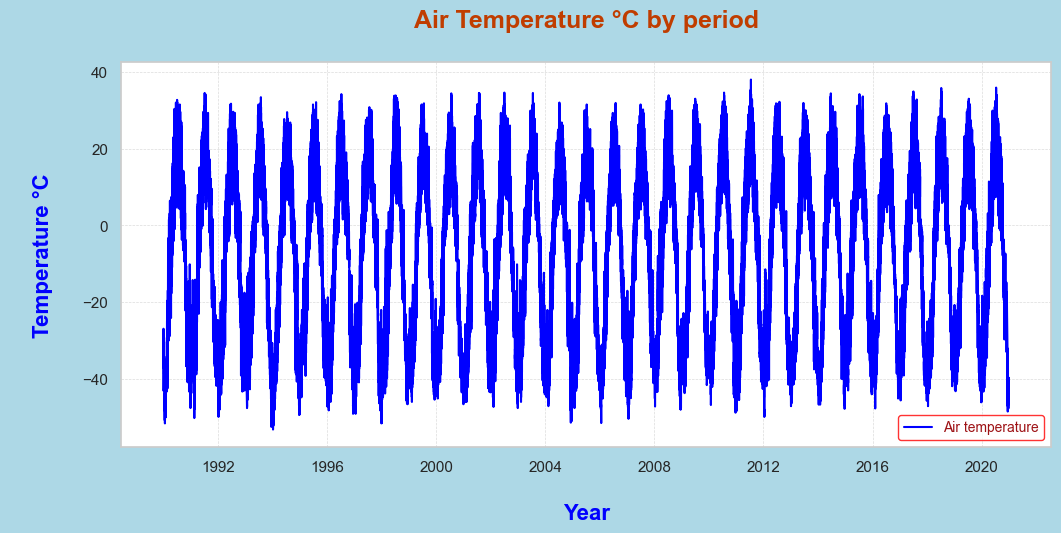

In [45]:
def prm(fs=15, ff='Arial', fw='bold', clr='black'):
    return {'fontsize': fs, 'fontfamily': ff, 'fontweight': fw, 'color': clr}

fig, ax = plt.subplots(figsize=(12, 5), facecolor='lightblue')
ax.plot(df, color='blue', label='Air temperature')
ax.legend()
ax.legend(fontsize=10, edgecolor='red', labelcolor='#9E1316')
ax.set_title('Air Temperature °С by period\n', prm(fs=18, clr='#C03D00'))
ax.set_xlabel('\nYear', prm(fs=16, clr='blue'))
ax.set_ylabel('\nTemperature °С\n', prm(fs=16, clr='blue'))
ax.grid(True)
fig.show();

Циклический график температуры воздуха. К середине года (лето) температура увеличивается, в начале и в конце года уменьшается до минусовых значений. Что покажет описательная статистика?

In [46]:
df.describe().T

count      mean        std   min   25%  50%   75%   max
t_air  90584.0 -7.843844  21.841433 -53.3 -29.1 -4.0  11.3  38.0

Средняя температура -7.8°С, климат холодный. Судя по максимальной температуре +38.0°С летом в городе очень жарко. Посмотрим на поведение средней температуры по часам.

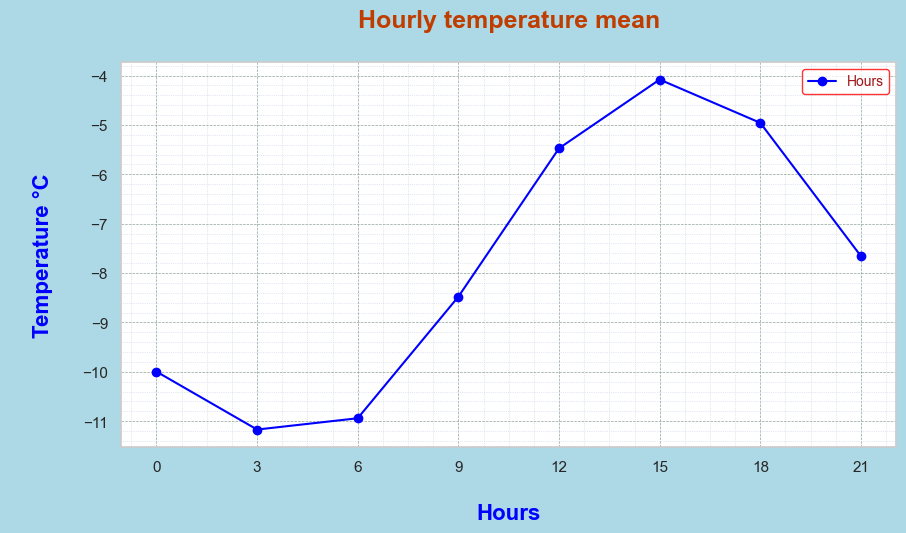

In [47]:
h_mean=df.groupby(df.index.hour).mean()

fig, ax = plt.subplots(figsize=(10, 5), facecolor='lightblue')
ax.plot(h_mean, 'o-', color='blue', label='Hours')
ax.legend()
ax.legend(fontsize=10, edgecolor='red', labelcolor='#9E1316')
ax.set_title('Hourly temperature mean\n', prm(fs=18, clr='#C03D00'))
ax.set_xlabel('\nHours', prm(fs=16, clr='blue'))
ax.set_ylabel('\nTemperature °С\n', prm(fs=16, clr='blue'))
ax.grid(color='#8DA399', linewidth=0.5)
ax.minorticks_on()
ax.grid(which='minor', color='#C8D1E5', linestyle=':', linewidth=0.5)
ax.set_xticks([0,3,6,9,12,15,18,21,])
fig.show();

Средняя максимальная температура за 31 год: -4.15°С, минимальная: -11.2°С. К трём часам пополудни температура повышается до максимума и к вечеру, по ночам и к утру опускается. Здесь не совсем почасовая температура, а каждые три часа, так как у метеорологов-наблюдателей сроки снятия показаний каждые три часа. Рассмотрим среднюю температуру по месяцам.

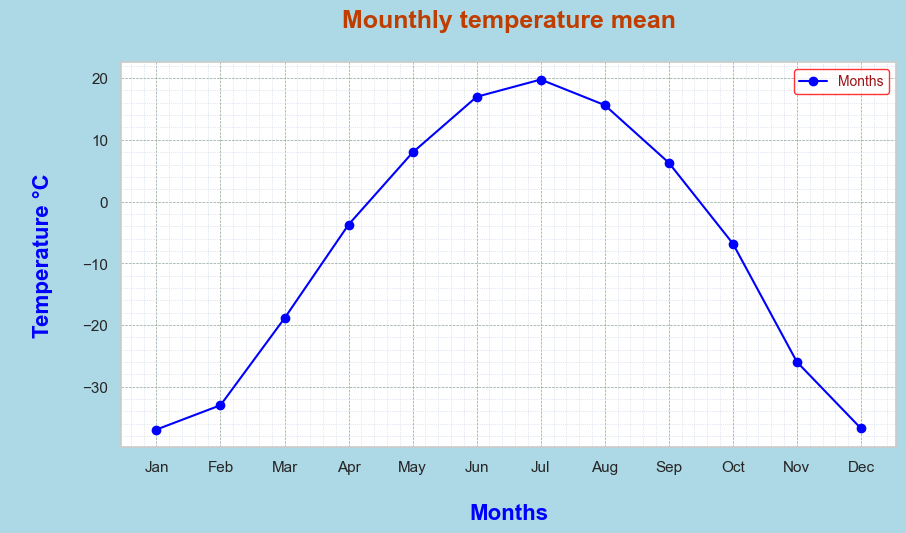

In [48]:
m_mean=df.groupby(df.index.month).mean()

fig, ax = plt.subplots(figsize=(10, 5), facecolor='lightblue')
ax.plot(m_mean, 'o-', color='blue', label='Months')
ax.legend()
ax.legend(fontsize=10, edgecolor='red', labelcolor='#9E1316')
ax.set_title('Mounthly temperature mean\n', prm(fs=18, clr='#C03D00'))
ax.set_xlabel('\nMonths', prm(fs=16, clr='blue'))
ax.set_ylabel('\nTemperature °С\n', prm(fs=16, clr='blue'))
ax.grid(color='#8DA399', linewidth=0.5)
ax.minorticks_on()
ax.grid(which='minor', color='#C8D1E5', linestyle=':', linewidth=0.5)
ax.set_xticks(range(1,13))
ax.set_xticklabels(['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 
                    'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec'])
fig.show();

Как и ожидалось, самый жаркий месяц ─ это июль, а самые холодные ─ январь и декабрь. Интересно, а как выглядит среднегодовая температура?

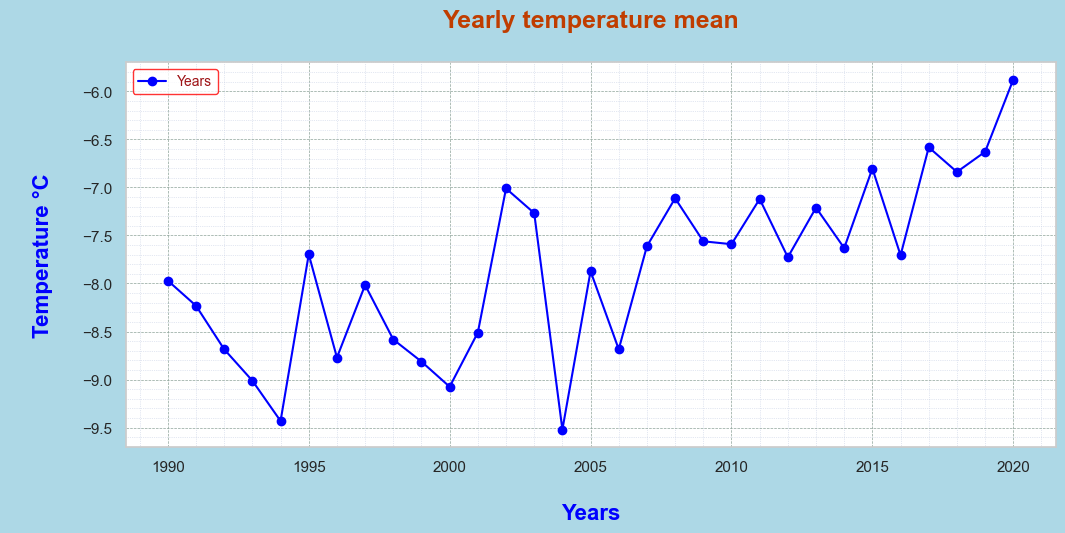

In [49]:
y_mean=df.groupby(df.index.year).mean()
fig, ax = plt.subplots(figsize=(12, 5), facecolor='lightblue')
ax.plot(y_mean, 'o-', color='blue', label='Years')
ax.legend()
ax.legend(fontsize=10, edgecolor='red', labelcolor='#9E1316')
ax.set_title('Yearly temperature mean\n', prm(fs=18, clr='#C03D00'))
ax.set_xlabel('\nYears', prm(fs=16, clr='blue'))
ax.set_ylabel('\nTemperature °С\n', prm(fs=16, clr='blue'))
ax.grid(color='#8DA399', linewidth=0.5)
ax.minorticks_on()
ax.grid(which='minor', color='#C8D1E5', linestyle=':', linewidth=0.5)
fig.show();

Диаграмма среднегодовой температуры показывает, что самый холодный год ─ это 2004, самый тёплый ─ 2020. Ещё видно, что с годами температура становится всё выше, словно глобальное потепление не за горами. Но это прояснит только время, может такой подъём температуры ─ это просто часть какой-нибудь долгопериодичной цикличности.  

За такой большой срок кадр температур воздуха по каждому сроку (каждые 3 часа) интерпретировать весьма сложно. Поэтому необходимо провести передискретизацию на дни, потом на месяцы, при этом агрегируем на среднее значение. Затем посмотрим, что получилось.

In [50]:
df_day = df.resample('D').mean()
print(f"Ресемплировано строк: {df.shape[0]-df_day.shape[0]}")

Ресемплировано строк: 79261


Ресемплируем по месяцам и посмотрим диграмму по ним.

In [51]:
df_mon = df_day.resample('M').mean()
print(f"Ресемплировано строк: {df_day.shape[0]-df_mon.shape[0]}")

Ресемплировано строк: 10951


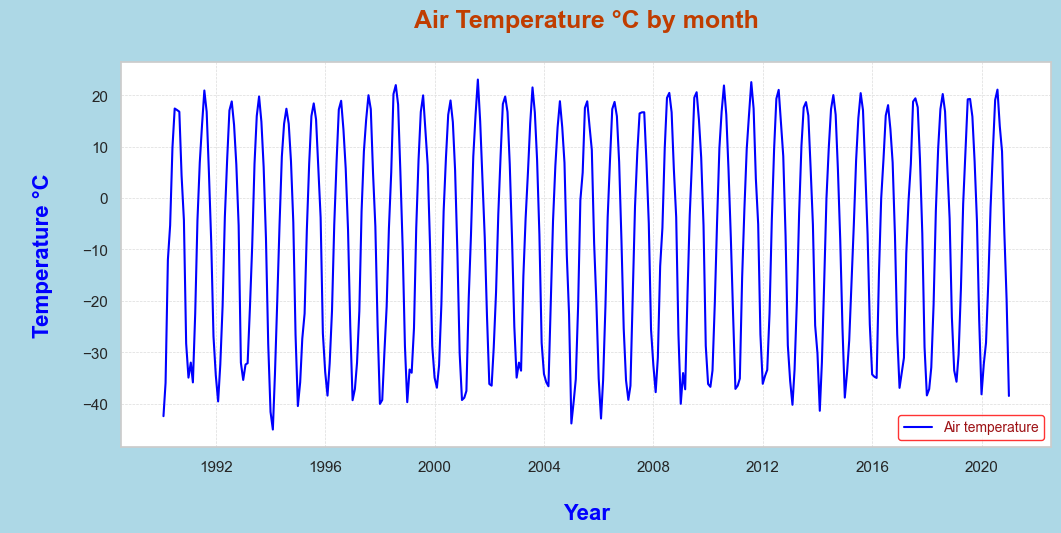

In [52]:
fig, ax = plt.subplots(figsize=(12, 5), facecolor='lightblue')
ax.plot(df_mon.t_air, color='blue', label='Air temperature')
ax.legend(fontsize=10, edgecolor='red', labelcolor='#9E1316')
ax.set_title('Air Temperature °С by month\n', prm(fs=18, clr='#C03D00'))
ax.set_xlabel('\nYear', prm(fs=16, clr='blue'))
ax.set_ylabel('\nTemperature °С\n', prm(fs=16, clr='blue'))
ax.grid(True)
fig.show();

Теперь на графике показана температура за все года по месяцам. Исчезла "лохматость" на пиках, график стал более ровным.  
  
А теперь разделим данные на тренировочную и тестовую выборки.

<font color = '#360CCC'>

### **7.2. Выборки train и test. Декомпозиция. Скользящее среднее** <a class="anchor" id="7.2"></a>
</font>

Выбираем точно также, как делали это для линейной регрессии.

In [53]:
# train-выборка от 1990 по 2017.  
train = df_mon.loc[:'2017-12-31']

# test-выборка от 2018 по 2020.  
test = df_mon.loc['2018-01-31':]

Проведём декомпозицию по месячному временному ряду тренировочной выборки.  

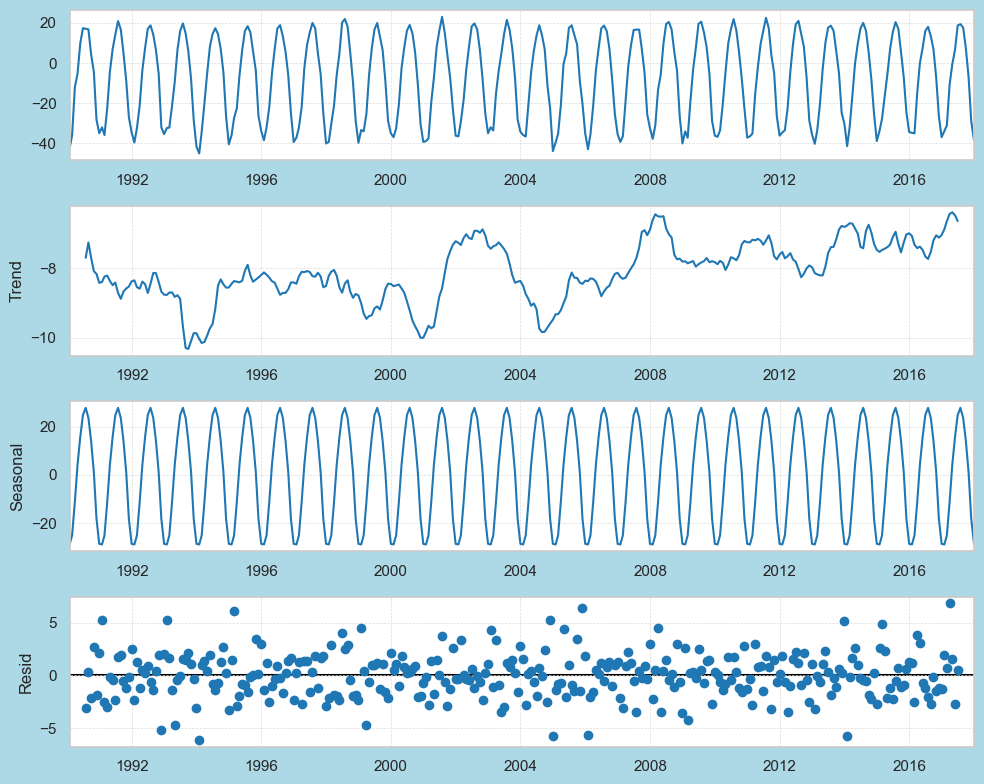

In [54]:
# Декомпозиция, визуализация исходного ряда train.  
result = seasonal_decompose(train, model='additive')
fig = result.plot()
fig.set_size_inches(10, 8)
plt.show();

Как мы видим, тренд практически отсутствует, есть сезонность и некоторый шум. Ряд, скорее всего нестационарен, но точнее определить это нам помогут тесты, котороые проведём чуть позже.  
Сейчас построим модель скользящего среднего используя метод сглаживания `rolling()` и визуализируем полученный результат.

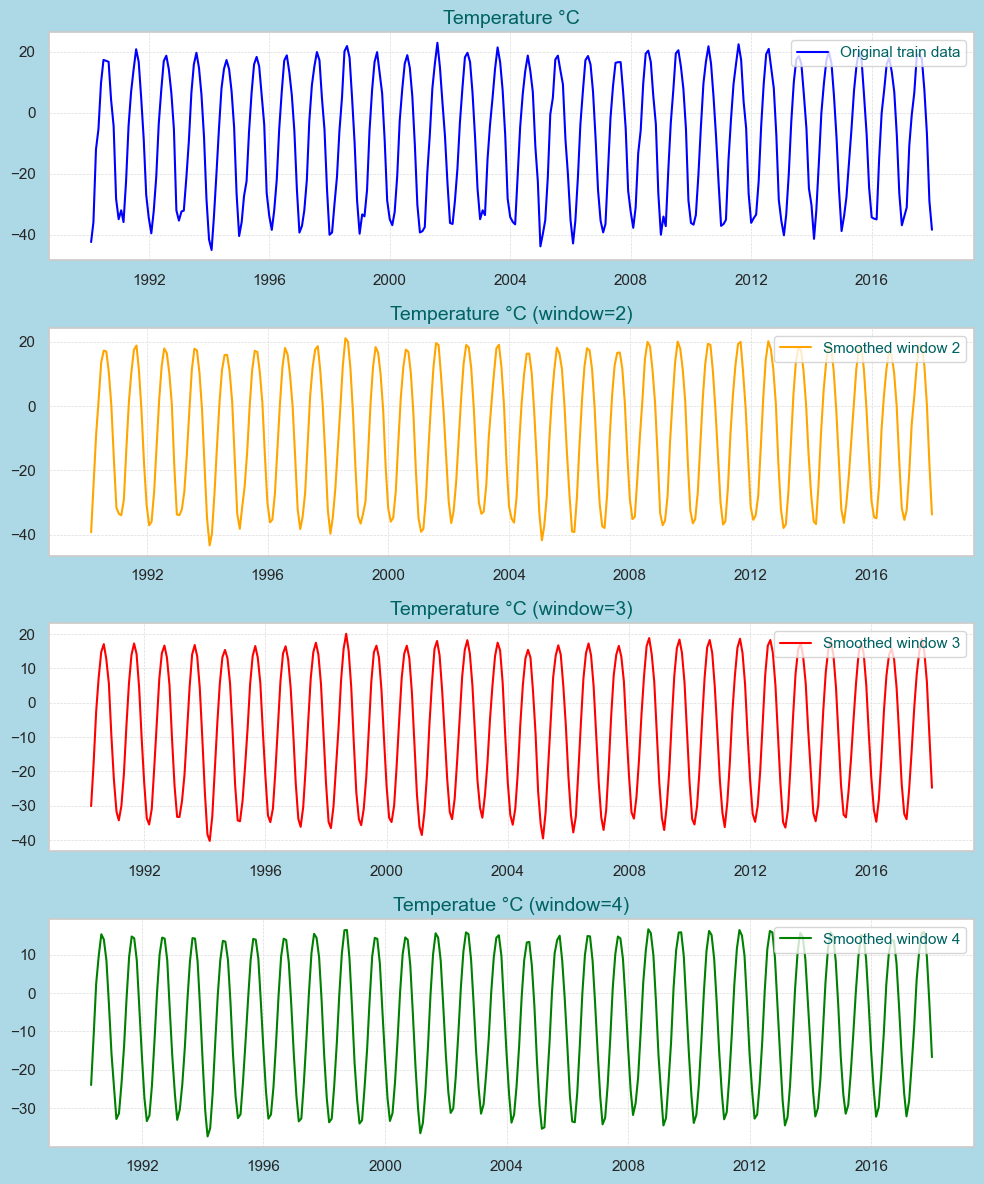

In [55]:
# визуализация временного ряда со скользящим средним
fig, ax = plt.subplots(4, 1, figsize=(10, 12))

ax[0].plot(train, color = "blue", 
              label = "Original train data")
ax[0].set_title("Temperature °С", size = 14)
ax[0].legend(loc='upper right')
ax[1].plot(train.rolling(2).mean(), 
              color = "orange", label = "Smoothed window 2")
ax[1].set_title("Temperature °С (window=2)", size = 14)
ax[1].legend(loc='upper right')

ax[2].plot(train.rolling(3).mean(), 
              color = "red", label = "Smoothed window 3")
ax[2].set_title("Temperature °С (window=3)", size = 14)
ax[2].legend(loc='upper right')

ax[3].plot(train.rolling(4).mean(), 
              color = "green", label = "Smoothed window 4")
ax[3].set_title("Temperatue °С (window=4)", size = 14)
ax[3].legend(loc='upper right')
plt.tight_layout();

Как видно из графиков, скользящее среднее с окном в 2 и выше месяцев слишком эффективны. Мы получаем чуть ли не синусоиду, при этом срок в два месяца и более. Поэтому оставляю исходный, первый вариант.  
  
Проверим ряд на стационарность с помощью метода Дики-Фуллера.

In [56]:
# Тест Дики ─ Фуллера
adfuller_test(train)

Statistics: -2.9186755357638865
p-value: 0.043218989749360344
Lags: 15
Observations: 320
Critical values: {'1%': -3.450951662384033, '5%': -2.8706147570800784, '10%': -2.571604931640625}

Полученные данные показывают, что нулевую гипотезу(Ho) можно отвергнуть. 
Ряд стационарен.


Вот и оказалось предположение, что ряд нестационарен, неверным. Тест нам помог в этом разобраться.  
Построим диаграммы ACF и PACF, попробуем определиться с ***d***.

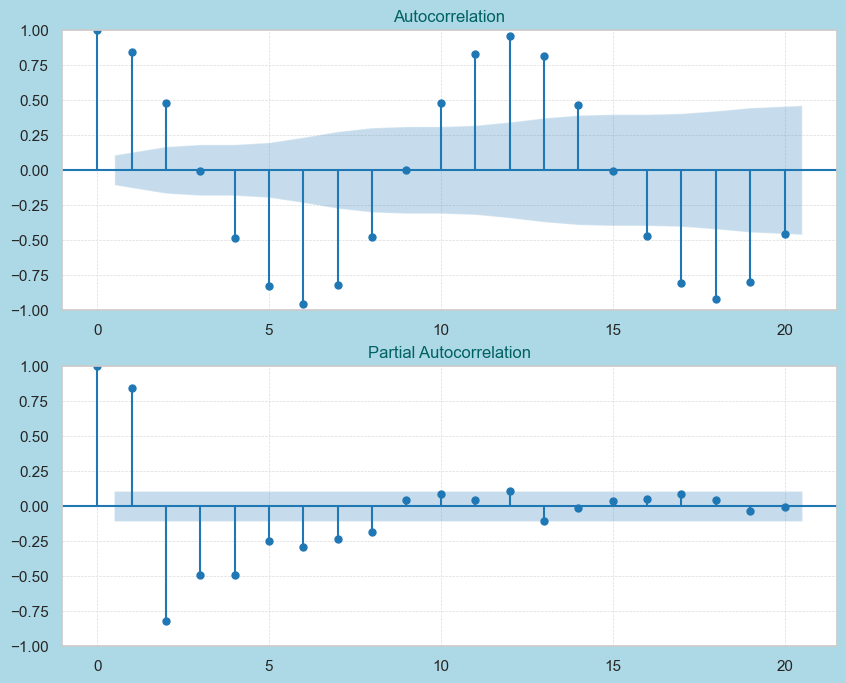

In [57]:
# Диаграммы ACF и PACF стационарного ряда
plot_acf_pacf(train['t_air'].dropna(), 0.05, 20, 10, 8)

По диаграммам сложно определиться. Выберем лучшие параметры с помощью кода ниже. Происходит циклическое обучение модели SARIMAX с разными параметрами, определяется AIC и по величине AIC определяются лучшие параметры для модели.

In [58]:
# Создание списков с кортежами значений.  
import time
p=d=q = range(0,2)
pdq_params = list(itertools.product(p, d, q))
pdq_season=[(x[0], x[1], x[2], 12) for x in list(itertools.product(p,d,q))]

# Словарь для справочных данных.  
aic_dic = dict()

# Перебор параметров, определение AIC.  
for pdq_p in pdq_params:
    for pdq_s in pdq_season:
        try:
            model=SARIMAX(
                train,
                order=pdq_p,
                seasonal_order=pdq_s)
            result=model.fit(disp=False, method='lbfgs')
            print("Selection of AIC:", result.aic, end='\r')
            aic_dic[f'SARIMAX: {pdq_p} x {pdq_s}'] = result.aic
        except:
            continue
        time.sleep(0.01)
    
aic = list(aic_dic.items())
aic.sort(key=lambda i: i[1])
display(aic)
print("Лучшие параметры:", aic[0])

[('SARIMAX: (0, 1, 1) x (0, 1, 1, 12)', 1514.3301034218161),
 ('SARIMAX: (0, 0, 0) x (0, 1, 1, 12)', 1514.6506664196602),
 ('SARIMAX: (0, 0, 1) x (0, 1, 1, 12)', 1515.8247096066743),
 ('SARIMAX: (1, 0, 0) x (0, 1, 1, 12)', 1515.8717271577434),
 ('SARIMAX: (1, 1, 1) x (0, 1, 1, 12)', 1515.941880502521),
 ('SARIMAX: (0, 1, 1) x (1, 1, 1, 12)', 1516.2566037287304),
 ('SARIMAX: (1, 0, 1) x (0, 1, 1, 12)', 1516.2580004048907),
 ('SARIMAX: (0, 0, 0) x (1, 1, 1, 12)', 1516.6252192807294),
 ('SARIMAX: (0, 0, 1) x (1, 1, 1, 12)', 1517.8079260086736),
 ('SARIMAX: (1, 0, 0) x (1, 1, 1, 12)', 1517.8535513709148),
 ('SARIMAX: (1, 1, 1) x (1, 1, 1, 12)', 1518.0160840658198),
 ('SARIMAX: (1, 0, 1) x (1, 1, 1, 12)', 1518.256575616308),
 ('SARIMAX: (1, 0, 1) x (1, 1, 0, 12)', 1572.0408919738234),
 ('SARIMAX: (0, 0, 0) x (1, 1, 0, 12)', 1575.4285383520107),
 ('SARIMAX: (0, 0, 1) x (1, 1, 0, 12)', 1576.8651501200984),
 ('SARIMAX: (1, 0, 0) x (1, 1, 0, 12)', 1576.924070855157),
 ('SARIMAX: (0, 1, 1) x (1,

Лучшие параметры: ('SARIMAX: (0, 1, 1) x (0, 1, 1, 12)', 1514.3301034218161)


In [59]:
# Создаём модель.  
model = SARIMAX(train,
                order = (0, 1, 1),
                seasonal_order = (0, 1, 1, 12)).fit()

# Описание лучшей модели
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                     SARIMAX Results                                      
==========================================================================================
Dep. Variable:                              t_air   No. Observations:                  336
Model:             SARIMAX(0, 1, 1)x(0, 1, 1, 12)   Log Likelihood                -754.165
Date:                            Thu, 11 May 2023   AIC                           1514.330
Time:                                    14:34:35   BIC                           1525.663
Sample:                                01-31-1990   HQIC                          1518.854
                                     - 12-31-2017                                         
Covariance Type:                              opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ma.L1         -0.9996      0.604     -1.655      0.098      -2.183       0.184
ma.S.L12      -0.9396      0.051    -18.337      0.000      -1.040      -0.839
sigma2         5.6036      3.300      1.698      0.089      -0.864      12.071
===================================================================================
Ljung-Box (L1) (Q):                   0.71   Jarque-Bera (JB):                13.31
Prob(Q):                              0.40   Prob(JB):                         0.00
Heteroskedasticity (H):               0.75   Skew:                            -0.11
Prob(H) (two-sided):                  0.13   Kurtosis:                         3.97
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

<font color = '#360CCC'>

### **7.3. Итоговая диаграмма модели SARIMAX. Метрики** <a class="anchor" id="7.3"></a>

</font>

Создадим датафрейм с предсказаниями модели и затем построим диаграмму с тестовыми и предсказанными данными.

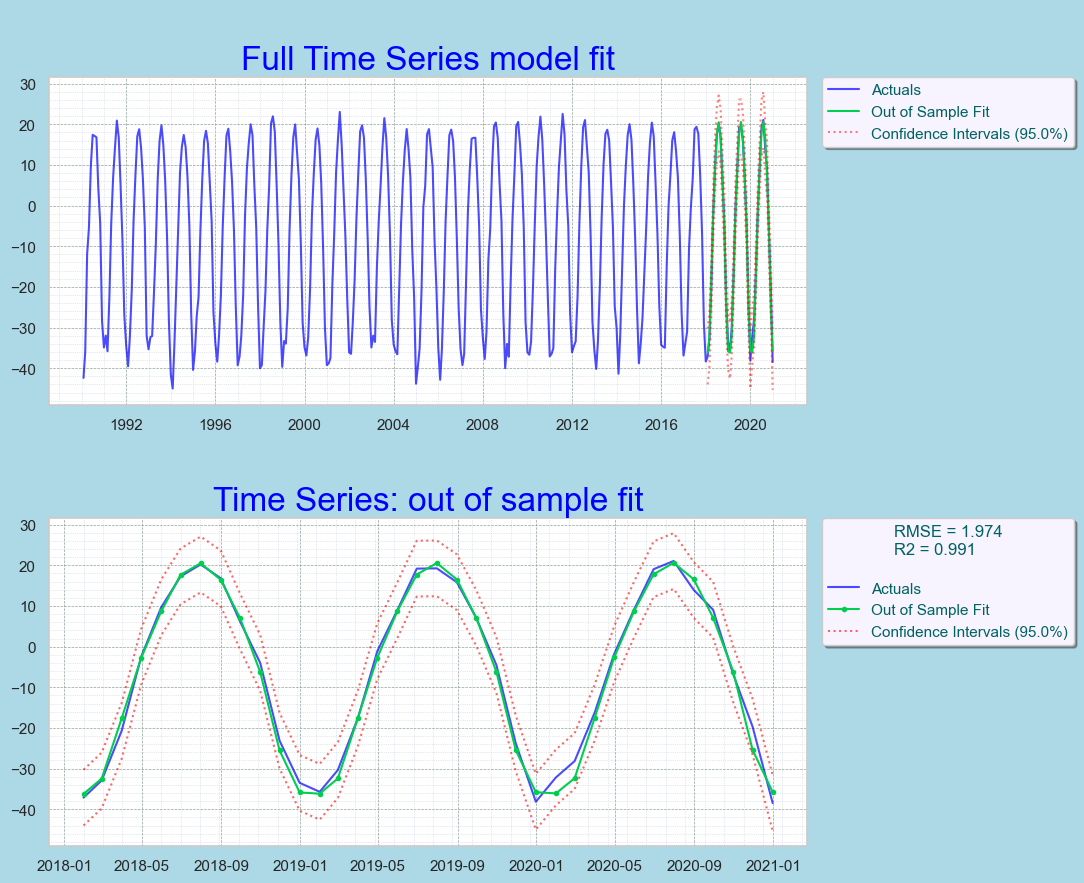

In [60]:
# Заполняем фрейм.  
df_predict(ts=True)

# Строим диаграмму.  
full_graph('Time Series', 'ts_predicted').show();

Весьма неплохой результат. Предсказанные значения температуры почти закрывают собой реальные значения, всё находится в границах доверительного интервала. Метрики показывают хороший результат. Немного февраль и март 2020 выбиваются из общей линии.  

А теперь спрогнозируем новые данные с декабря 2020 года по декабрь 2023 года. Построим график предсказанной среднемесячной температуры в северном городке за 2023 год.

In [61]:
predict_date = pd.date_range(start="2020-12-31",end="2023-12-31",freq="M")
pred = model.get_prediction(
    start=len(df_mon),
    end=(len(df_mon)+len(predict_date)-1))
dfp = pd.DataFrame(pred.predicted_mean)
dfp.reset_index().set_index('index', inplace=True)

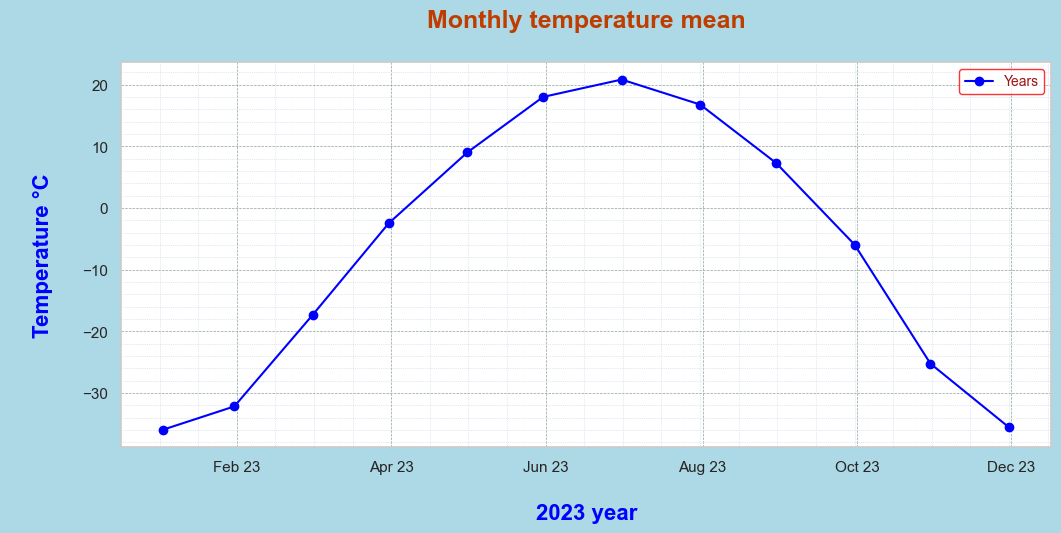

In [62]:
fig, ax = plt.subplots(figsize=(12, 5), facecolor='lightblue')
ax.plot(dfp[24:-1], 'o-', color='blue', label='Years')
ax.legend()
ax.legend(fontsize=10, edgecolor='red', labelcolor='#9E1316')
ax.set_title('Monthly temperature mean\n', prm(fs=18, clr='#C03D00'))
ax.set_xlabel('\n2023 year', prm(fs=16, clr='blue'))
ax.set_ylabel('\nTemperature °С\n', prm(fs=16, clr='blue'))
ax.grid(color='#8DA399', linewidth=0.5)
ax.minorticks_on()
ax.grid(which='minor', color='#C8D1E5', linestyle=':', linewidth=0.5)
ax.set_xticklabels(['Feb 23', 'Apr 23', 'Jun 23', 
                    'Aug 23', 'Oct 23', 'Dec 23'])
fig.show();

Ну что ж, хоть и средняя температура, но видимо никаких катаклизмов не ожидается, как всегда летом ─ жара и изредка ливневые дожди с грозами. К погоде я готов. :)  
  
Под занавес временных рядов взглянем на диагностическую диаграмму модели.

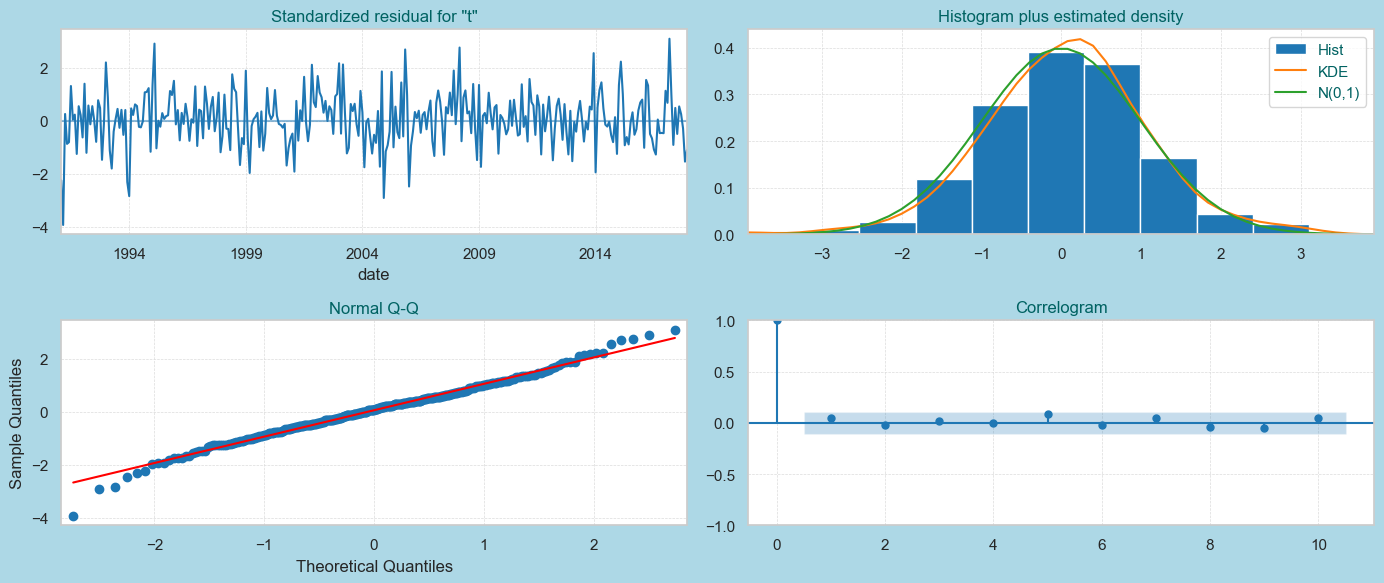

In [63]:
model.plot_diagnostics(figsize=(14,6))
plt.tight_layout()
plt.show()

Вот что сообщает нам диаграмма:  
* Стандартизированные остатки сезонности не имеют, вернее, что-то наблюдается, но чрезвычайно мало. Скажем так: не совсем белый шум.  
  
* По гистограмме расчётной плотности мы видим, что KDE почти совпадает с нормальным распределением N. Это говорит о том, что полученная модель подходит для построения прогноза.  
  
* График распределения Normal Q-Q показывает, что упорядоченное распределение остатков (синие точки), в большинстве своём, соответствуют линейному тренду выборок из нормального распределения N (красная линия). Это показывает, что остатки распределены нормально.  
  
* Кореллограмма показывает, что остатки временного ряда имеют низкую корреляцию.
  
Ну прямо-таки идеал, хоть молись на него. Конечно же это не так, и если разбирать подробно данную модель, то много подводных камней можно найти. Но, тем не менее, модель временных рядов показала неплохой результат и мы переходим к построению нейронной модели.

<center><font color = '#360CCC'>

# **8. Нейронная модель** <a class="anchor" id="8"></a>
-----------------------------------
</font></center>

<font color = '#360CCC'>

### **8.1 Подготовка данных** <a class="anchor" id="8.1"></a>
</font>

Мы уже провели необходимый анализ и сделали выводы по диаграммам. Поэтому сейчас сразу же займёмся нейронной моделью. Ранее мы разделили датасет на train и test, оставив один признак `t_air`. Эти фреймы используем и в этом случае.  
  
В первую очередь, необходимо масштабировать данные, это действие категорически необходимо для построения нейронных сетей. Используем метод MinMaxScaler(). 

In [64]:
print('Train', train.head(2), '\n\nTest', test.head(2))
mm_scal = MinMaxScaler()
train_scale = mm_scal.fit_transform(train)
test_scale = mm_scal.transform(test)

Train                 t_air
date                 
1990-01-31 -42.405645
1990-02-28 -35.930804 

Test                 t_air
date                 
2018-01-31 -37.138306
2018-02-28 -32.926786


Используя вспомогательный класс TimeserGenerator(), объявим переменную generator для создания пакетов временных данных.

In [65]:
# 12 месяцев, определяем time_step
time_step = 12
generator=TimeseriesGenerator(data=train_scale,
                              targets=train_scale,
                              length=time_step,
                              batch_size=1
                             )

Сгруппируем слои и построим нейронную модель с помощью Sequential():

In [66]:
model = tf.keras.models.Sequential([
  tf.keras.layers.LSTM(100, activation="relu", 
                       input_shape=(time_step, 1), return_sequences=True),
  tf.keras.layers.Dropout(0.2),
  tf.keras.layers.LSTM(64, activation="relu"),
  tf.keras.layers.Dropout(0.01),
  tf.keras.layers.Dense(32),
  tf.keras.layers.Dense(1)
])

# Если нет изменений, то остановиться после 50 эпох.  
callback = [EarlyStopping(monitor="loss", patience=50)]

# Собираем модель.  
model.compile(optimizer = Adam(learning_rate=0.001),
              loss="mean_squared_error",
              metrics=["mse"])

А сейчас можно выпить чашечку кофе, процесс далее долгий. В зависимости от мощности компьютера от 5 до 10 минут. Что же происходит? Происходит циклическое обучение нейросети (50 циклов). Все результаты сохраняются в словарь. По окончании происходит автоматический выбор наилучшей модели, вывод RMSE и R2 для неё.

<font color = '#360CCC'>

### **8.2 Обучение и поиск лучшего прогноза**  <a class="anchor" id="8.2"></a>
</font>

In [67]:
r_lst = []
best_dic = dict()
for step in range(1, 51):
    model.fit(generator, epochs=200, steps_per_epoch=18, 
              verbose=False, callbacks=callback)
    test_pred=[]
    test_batch=train_scale[-time_step:]
    current_batch=test_batch.reshape(1,time_step,1)
    
    for i in range(len(test)):
        pred = model.predict(current_batch, verbose=0)[0]
        test_pred.append(pred)
        current_batch=np.append(current_batch[:,1:,:],[[pred]],axis=1)
    
    true_pred=mm_scal.inverse_transform(test_pred)
    test["predicted"] = true_pred
    metric = rmse(test.t_air, test.predicted)
    best_dic[f'RMSE: {metric}', step] = test['predicted'].to_list()
    r_lst.append(metric)
    print(f"Step: {step}, current RMSE: {metric}, best RMSE: {np.min(r_lst)}  ",
          end='\r')

best = list(best_dic.items())
best.sort(key=lambda i: i[0])
print(*[' ' for i in range(50)], end='\r')
print(f"The best {best[0][0][0]} is shown in the Step {best[0][0][1]}")
test['predicted'] = best[0][1]

The best RMSE: 2.364 is shown in the Step 27                                                       


<font color = '#360CCC'>

### **8.3. Итоговая диаграмма нейронной модели. Метрики** <a class="anchor" id="8.3"></a>
</font>

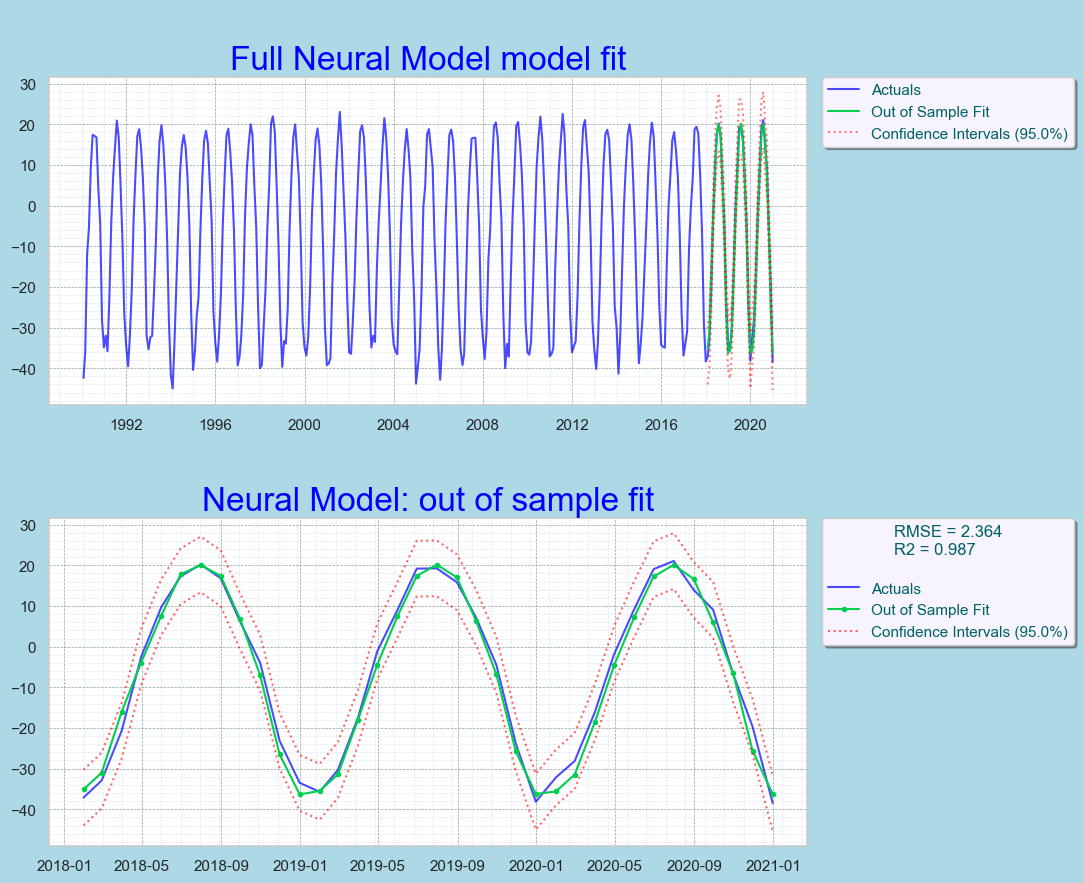

In [68]:
# Заполняем фрейм.  
df_predict(nm=True)

# Строим диаграмму.  
full_graph('Neural Model', 'nm_predicted').show();

<font color = '#360CCC'>

# **9. Заключительные результаты по всем моделям** <a class="anchor" id="9"></a>
--------------------------
</font>

Выведем результаты всех трёх моделей и сделаем выводы.

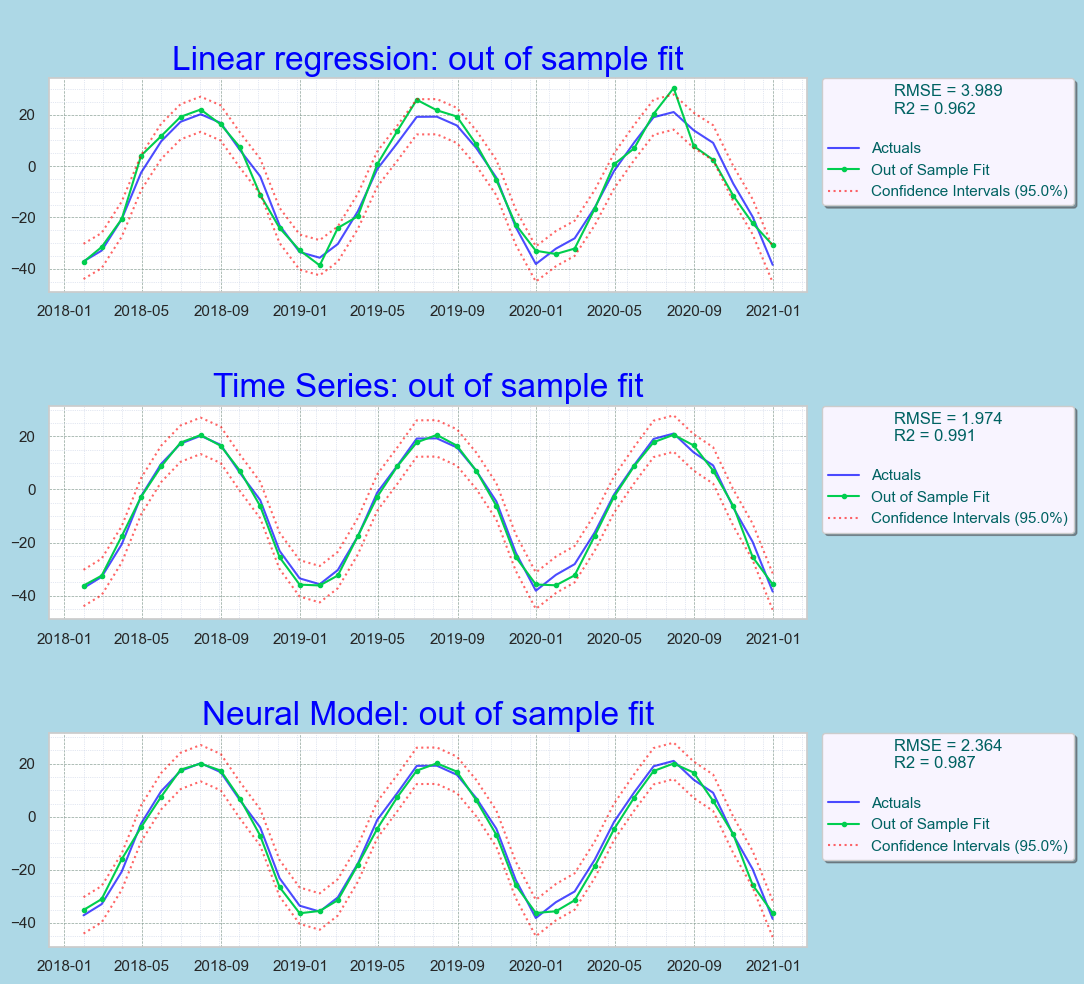

In [69]:
plt.rcParams["text.color"] = '#006262'
fig, ax = plt.subplots(figsize=(11, 10), facecolor='lightblue')
rm = rmse(y_test, prediction.lr_predicted)
r2 = r2_score(y_test, prediction.lr_predicted).round(3)

plt.subplot(3,1,1)
plt.plot(prediction.loc[lst_indx_test]['t_air'], 
        color = "blue", label = "Actuals", alpha=0.7)
plt.plot(prediction.loc[lst_indx_test]['lr_predicted'], 
        color = "#00CE4F", linestyle = "-", marker='.',
        label = "Out of Sample Fit")
plt.plot(prediction.loc[lst_indx_test]["predict_low"], 
        color = "red", linestyle = ":", 
        label = f"Confidence Intervals ({prediction.alpha[0]*100}%)",
        alpha = 0.6)
plt.plot(prediction.loc[lst_indx_test]["predict_up"], 
        color = "red", linestyle = ":", alpha = 0.6)
plt.title(f"\nLinear regression: out of sample fit", size = 24, color='blue')
plt.legend(title=f'RMSE = {rm}\nR2 = {r2}\n', shadow=True, 
            facecolor='#F8F4FF',
        bbox_to_anchor=( 1.02 , 1 ), borderaxespad=0)
plt.grid(color='#8DA399', linewidth=0.5)
plt.minorticks_on()
plt.grid(which='minor', color='#C8D1E5', linestyle=':', linewidth=0.5)

rm = rmse(y_test, prediction.ts_predicted)
r2 = r2_score(y_test, prediction.ts_predicted).round(3)
plt.subplot(3,1,2)
plt.plot(prediction.loc[lst_indx_test]['t_air'], 
        color = "blue", label = "Actuals", alpha=0.7)
plt.plot(prediction.loc[lst_indx_test]['ts_predicted'], 
        color = "#00CE4F", linestyle = "-", marker='.',
        label = "Out of Sample Fit")
plt.plot(prediction.loc[lst_indx_test]["predict_low"], 
        color = "red", linestyle = ":", 
        label = f"Confidence Intervals ({prediction.alpha[0]*100}%)",
        alpha = 0.6)
plt.plot(prediction.loc[lst_indx_test]["predict_up"], 
        color = "red", linestyle = ":", alpha = 0.6)
plt.title(f"\nTime Series: out of sample fit", size = 24, color='blue')
plt.legend(title=f'RMSE = {rm}\nR2 = {r2}\n', shadow=True, 
            facecolor='#F8F4FF',
        bbox_to_anchor=( 1.02 , 1 ), borderaxespad=0)
plt.grid(color='#8DA399', linewidth=0.5)
plt.minorticks_on()
plt.grid(which='minor', color='#C8D1E5', linestyle=':', linewidth=0.5)
plt.tight_layout()

rm = rmse(y_test, prediction.nm_predicted)
r2 = r2_score(y_test, prediction.nm_predicted).round(3)
plt.subplot(3,1,3)
plt.plot(prediction.loc[lst_indx_test]['t_air'], 
        color = "blue", label = "Actuals", alpha=0.7)
plt.plot(prediction.loc[lst_indx_test]['nm_predicted'], 
        color = "#00CE4F", linestyle = "-", marker='.',
        label = "Out of Sample Fit")
plt.plot(prediction.loc[lst_indx_test]["predict_low"], 
        color = "red", linestyle = ":", 
        label = f"Confidence Intervals ({prediction.alpha[0]*100}%)",
        alpha = 0.6)
plt.plot(prediction.loc[lst_indx_test]["predict_up"], 
        color = "red", linestyle = ":", alpha = 0.6)
plt.title(f"\nNeural Model: out of sample fit", size = 24, color='blue')
plt.legend(title=f'RMSE = {rm}\nR2 = {r2}\n', shadow=True, 
            facecolor='#F8F4FF',
        bbox_to_anchor=( 1.02 , 1 ), borderaxespad=0)
plt.grid(color='#8DA399', linewidth=0.5)
plt.minorticks_on()
plt.grid(which='minor', color='#C8D1E5', linestyle=':', linewidth=0.5)
plt.tight_layout()
plt.show();


<font color = '#360CCC'>

# **Выводы** <a class="anchor" id="10"></a>
-----------------------
</font>

Была проделана работа по построению прогностических моделей линейной регрессии, временных рядов (модель SARIMAX) и модели нейронной сети. Наилучший результат показала модель SARIMAX, на втором месте нейронная модель и замыкает список модель линейной регрессии. Чтобы объективно иссследовать эти три модели, необходимо учитывать большое количество нюансов. Например, если взять нейронную модель, то класс TimeseriesGenerator уже устарел, что явно не идёт на пользу прогнозу. Тем не менее, мы провели сравнительный анализ и его результат налицо: результирующая диаграмма показывает, что прогнозы Sarimax и нейросети укладываются в 95%-ый доверительный интервал и показывают хорошие метрики. Хочу предупредить, что результат нейромодели всегда будет разным, но в среднем будет показывать одинаковые метрики. 

<font color = '#360CCC'>

# **Docker HUB** <a class="anchor" id="11"></a>
-----------------------
</font>

На хаб Docker выложил <a href="https://hub.docker.com/r/gluzionar/final_project"><font color='green'><u>докер-образ</u></font></a> файла итогового проекта. При создании докер-образа библиотека tensorflow конфликтовала с системой Linux, которую использует докер. Причем, это не моя ошибка в установке библиотеки, а значимая проблема у создателей tensorflow. В интернете об этом написано очень много, а на сайте производителя есть инструкция, как установить тензор на Linux. На свой ubuntu я его установил, работает, но вот при сборке докер-образа ─ проблемы. Поэтому в образе нет нейронной модели. Но всё остальное работает хорошо, проверял в системах Windows и Linux (ubuntu). Задачи решаются, код исполняется без проблем, графики строятся и сохраняются в папке `diagram`.  
  
Создайте любую папку, откройте PowerShell, зайдите через него в эту папку и запустите по очереди следующие команды:  
Загрузка.
`docker pull gluzionar/final_project`  
  
Запуск.
`docker run -it --rm -v $PWD/diagram/:/app/output/ --name project gluzionar/final_project`  
  
В Linux всё тоже самое, только вначале нужно добавлять `sudo`:  
`$ sudo docker pull gluzionar/final_project`  
`$ sudo docker run -it --rm -v $PWD/diagram/:/app/output/ --name project gluzionar/final_project`   